## Modules

In [1]:
import numpy as np 
import math
import peakutils
import numpy.fft as fft
#import matplotlib as mpl 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
#from matplotlib import cm  
from scipy.integrate import odeint 
import scipy.signal as signal 
from scipy.spatial import KDTree


import pickle 
#import random as rand  
from numpy import random
#from sklearn import decomposition 
from deap import creator, base, tools, algorithms 
from sklearn.decomposition import PCA
#from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans  
import os.path 

from SALib.sample import saltelli, fast_sampler, latin
from SALib.sample.morris import sample
from SALib.analyze import sobol, fast, morris, delta
from SALib.plotting.morris import horizontal_bar_plot, covariance_plot, sample_histograms

import glob 
import pathlib as Path
import shutil
from numba import njit, typed


## Oscillator class

In [2]:
'''
The deterministic model of biological oscillator
''' 
#@experimental.jitclass
class Oscillator: 
	def __init__(self, parameter_values, params, initial_conditions, dt = 0.1, mode = 1, sigma = 0.001, volume = 0.5): 
		self.nParams = len(params)   
		self.params = params #model parameters
		self.parameter_values = parameter_values #allowed parameter ranges  
		self.y0 = initial_conditions 
		self.volume = volume
		self.copynumbers = [self.copynumber(x) for x in self.y0]	
		self.dt = dt
		self.sigma = sigma
		self.T = 100 
		self.N = int(self.T/self.dt) 
		self.ts = np.linspace(0, self.T, self.N) 
		self.amp = 300 #[nM] 		
		self.per = self.T/8 	
		self.sample_rate 		= 0.0033333333 #Hz 
		self.samples_per_hour 	= (1/self.dt)		
		self.jump 				= int(self.samples_per_hour/(self.sample_rate*3600)) if int(self.samples_per_hour/(self.sample_rate*3600)) else 1 	 	
		self.ideal = self.amp*(np.sin(math.pi*(self.ts)/self.per - math.pi/2) + 1) 
		#number of samples for FFT		
		self.nS = self.N/self.jump 
		self.dF = self.sample_rate/self.nS  
		self.idealF = self.getFrequencies(self.ideal) 
		self.idealFreq = 0.3 #peaks per second 	
		self.penalty = 0.5 	
		thresholdOne = -(self.nS/2)*100 #10nM -+ from ideal signal harmonics       
		thresholdTwo = 0.1
		#self.maxFreq = 0.5
		#self.maxPeaks = self.maxFreq * self.T  
		self.minAmp = 1
		self.maxAmp = 6000 
		self.mode = mode    			
		self.modes = [self.eval]       
		self.threshold = thresholdOne  
		self.omega = 1000 #nm^-1 
		if self.mode == 1:
			self.threshold = thresholdTwo
	
	#gets summed difference of arrayData
	@staticmethod 	
	def getDif(indexes, arrayData):	
		arrLen = len(indexes)
		sum = 0
		for i, ind in enumerate(indexes):
			if i == arrLen - 1:
				break
			sum += arrayData[ind] - arrayData[indexes[i + 1]]
			
		#add last peak - same as substracting it from zero 
		sum += arrayData[indexes[-1:]]  
		return sum   
		
	#gets standard deviation 
	@staticmethod 
	def getSTD(indexes, arrayData, window):
		numPeaks = len(indexes)
		arrLen = len(arrayData)
		sum = 0
		for ind in indexes:
			minInd = max(0, ind - window)
			maxInd = min(arrLen, ind + window)
			sum += np.std(arrayData[minInd:maxInd])  
			
		sum = sum/numPeaks 	
		return sum	 
	
	def getFrequencies(self, y):
		#fft sample rate: 1 sample per 5 minutes
		y = y[0::self.jump]  
		res = abs(fft.rfft(y))
		#normalize the amplitudes 
		res = res/math.ceil(self.nS/2) 
		return res

	def costOne(self, Y): 
		p1 = Y[:,1]   
		fftData = self.getFrequencies(p1)     
		
		diff = fftData - self.idealF         
		cost = -np.dot(diff, diff) 		
		return cost,	
		
	def costTwo(self, Y, getAmplitude = False): 
		p1 = Y[:,5] 
		fftData = self.getFrequencies(p1)      
		fftData = np.array(fftData) 
		
		#find peaks using very low threshold and minimum distance
		#indexes = peakutils.indexes(fftData, thres=0.02/max(fftData), min_dist=1) 
		#find number of peaks in time domain for frequency threshold
		#peaknumber = len(peakutils.indexes(p1, thres=0.02/max(fftData), min_dist=1))  

		indexes = peakutils.indexes(fftData, thres=np.mean(fftData), min_dist=10, thres_abs = True) 
		#find number of peaks in time domain for frequency threshold
		peaknumber = len(peakutils.indexes(p1, thres=np.mean(p1), min_dist=1, thres_abs = True)) 

		#in case of no oscillations return 0 
		if len(indexes) == 0 or peaknumber == 0:
			return 0, 0 
		#if amplitude is greater than 400nM
		amp = np.max(fftData[indexes])
		if amp > self.maxAmp: 
			return 0,0 
		fitSamples = fftData[indexes]  			
		std = self.getSTD(indexes, fftData, 1)  
		diff = self.getDif(indexes, fftData)  
		penalty =  ((abs(self.idealFreq - (peaknumber/self.T)))*self.penalty)
		cost = std + diff #- penalty #penalize difference from ideal frequency
		#print(cost)   
		if getAmplitude:
			return cost, amp
		return cost#, penalty
		
	def isViableFitness(self, fit):
		return fit >= self.threshold
		
	def isViable(self, point): 
		fitness = self.eval(point, getAmplitude=True)  
		if self.mode == 0:
			return self.isViableFitness(fitness[0]) 
			
		fit = fitness[0] 
		amp = 0
		if fit > 0:
			amp = fitness[1] 
		return self.isViableFitness(fit) #and amp >= self.minAmp and amp <= self.maxAmp   
		
	#evaluates a candidate  
	def eval(self, candidate, getAmplitude = False): 
		Y = np.array(self.simulate(candidate)) 
		if self.mode == 0:
			return self.costOne(Y)  
		else:
			return self.costTwo(Y, getAmplitude = True)   #False before 7-26  

	def eval_fixedinitials(self, initials, params):
		Y = np.array(odeint(self.oscillatorModelOde, initials, self.ts, args=(typed.List(params),))) 
		return self.costTwo(Y, getAmplitude=True)
	
	#simulates a candidate
	def simulate(self, candidate): 
		#self.y0 = [candidate[13],0,candidate[14],candidate[15],0,candidate[16],0,0,0,0,0,0]
		return odeint(self.oscillatorModelOde, self.y0, self.ts, args=(typed.List(candidate),))   		

	def plotModel(self, subject, mode="ode", show=True):     		
		if mode == "ode":
			t = np.linspace(0, self.T, self.N)
			solutions = self.simulate(subject) 			
		else:
			#ssa simulation
			can = self.full_converter(subject, True)
			t,solutions = self.ssa(can)
			
		fig = plt.figure(figsize=(8,4),dpi=200)

		plt.plot(t,solutions[:,0], color="b", label = 'PIP')
		plt.plot(t,solutions[:,1], color="g", label = 'PIP2')
		#plt.plot(t,solutions[:,2], color="gold", label = 'K')
		#plt.plot(t,solutions[:,3], color="r", label = 'P')
		#plt.plot(t,solutions[:,4], color="cyan", label = 'LK')
		plt.plot(t,solutions[:,5], color="r", label = 'AP2')
		plt.plot(t,solutions[:,6], color="gold", label = 'PIP2-AP2')
		#plt.plot(t,solutions[:,7], color="yellow", label = 'LpAK')
		#plt.plot(t,solutions[:,8], color="magenta", label = 'LpAP')
		#plt.plot(t,solutions[:,9], color="deeppink", label = 'LpAPLp')
		#plt.plot(t,solutions[:,10], color="peru", label = 'LpAKL')
		#plt.plot(t,solutions[:,11], color="purple", label = 'LpP')


		plt.xlabel('Time (s)')
		plt.ylabel('Concentration (uM)')
		plt.legend(loc = 'upper right', bbox_to_anchor = (1.2,1)) #prop={'size': 6}
		plt.show()
			 				
	def getTotalVolume(self):
		vol = 1.0
		for param in self.params:		
			vol = vol*(self.parameter_values[param]["max"] - self.parameter_values[param]["min"])
		return vol 

	@staticmethod
	@njit(cache=True)
	def oscillatorModelOde(Y, t, can): 

		VA = can[12]
		
		sigma = 0.001

		ka1 = can[0]
		kb1 = can[1]
		kcat1 = can[2]

		ka2 = can[3]
		kb2 = can[4]

		ka3 = can[5]
		kb3 = can[6]

		ka4 = can[7]
		kb4 = can[8]

		ka7 = can[9]
		kb7 = can[10]
		kcat7 = can[11]

		ka5 = can[9]
		kb5 = can[10]
		kcat5 = can[11]

		ka6 = can[0]
		kb6 = can[1]
		kcat6 = can[2]

		#initial conditions
		L = Y[0]   # make sure in uM
		Lp = Y[1]
		K = Y[2]
		P = Y[3]
		LK = Y[4] 
		A = Y[5]
		LpA = Y[6] 
		LpAK = Y[7] 
		LpAP = Y[8] 
		LpAPLp = Y[9] 
		LpAKL = Y[10] 
		LpP = Y[11] 

		dL = (kb1*LK) - (ka1*L*K) + (kcat5*LpAPLp) + (kb6*LpAKL) - ((VA/(2*sigma))*ka6*LpAK*L) + (kcat7*LpP)
		dLp = (kcat1*LK) + (kb2*LpA) - (ka2*Lp*A) + (kb5*LpAPLp) - ((VA/(2*sigma))*ka5*Lp*LpAP) + (kcat6*LpAKL) - (ka7*Lp*P) + (kb7*LpP)
		dK = (kb1*LK) - (ka1*L*K) + (kcat1*LK) + (kb3*LpAK) - (ka3*LpA*K)
		dP = (kb4*LpAP) - (ka4*LpA*P) - (ka7*Lp*P) + (kb7*LpP) + (kcat7*LpP)
		dLK = (ka1*L*K) - (kb1*LK) - (kcat1*LK)
		dA = (kb2*LpA) - (ka2*Lp*A)
		dLpA = (ka2*Lp*A) - (kb2*LpA) + (kb3*LpAK) - (ka3*LpA*K) + (kb4*LpAP) - (ka4*LpA*P)
		dLpAK = (ka3*LpA*K) - (kb3*LpAK) + (kb6*LpAKL) - ((VA/(2*sigma))*ka6*LpAK*L) + (kcat6*LpAKL)
		dLpAP = (ka4*LpA*P) - (kb4*LpAP) + (kb5*LpAPLp) - ((VA/(2*sigma))*ka5*LpAP*Lp) + (kcat5*LpAPLp)
		dLpAPLp = ((VA/(2*sigma))*ka5*LpAP*Lp) - (kb5*LpAPLp) - (kcat5*LpAPLp)
		dLpAKL = ((VA/(2*sigma))*ka6*LpAK*L) - (kb6*LpAKL) - (kcat6*LpAKL)
		dLpP = (ka7*Lp*P) - (kb7*LpP) - (kcat7*LpP)

		return([dL, dLp, dK, dP, dLK, dA, dLpA, dLpAK, dLpAP, dLpAPLp, dLpAKL, dLpP])	
	
	def getPerAmp(self, subject, mode="ode", indx=0): 
		if mode == "ode":
			ts = np.linspace(0, self.T, self.N*100) 
			Y = self.simulate(subject)    				
		#else:
			#ts,Y = self.represilatorStochastic(subject) 
		ts = np.array(ts) 
		Y = np.array(Y) 
		sig = Y[:, indx]
		indx_max, properties = signal.find_peaks(sig, prominence = (np.max(sig) - np.min(sig))/4, distance = len(ts)/100)      
		indx_min, properties = signal.find_peaks(sig*-1, prominence = (np.max(sig) - np.min(sig))/4, distance = len(ts)/100)     

		amps = [] 
		pers = []   
		for i in range(min(len(indx_max), len(indx_min))):
			amps.append((sig[indx_max[i]] - sig[indx_min[i]])/2) 			
			if i + 1 < len(indx_max):
				pers.append(ts[indx_max[i + 1]] - ts[indx_max[i]])
			if i + 1 < len(indx_min):
				pers.append(ts[indx_min[i + 1]] - ts[indx_min[i]])
		
		if len(amps) > 0 and len(pers) > 0:
			amps = np.array(amps)   	
			pers = np.array(pers)  
			
			#print(amps)
			amp = np.mean(amps)	
			#print(pers) 
			per = np.mean(pers) 
		else:
			amp = 0
			per = 0  
		
		#print("amp" + str(amp)) 
		#print("per" + str(per))   	
		
		return per, amp 

	#@njit
	def ssa(self, can):
		#omega = self.omega
		#y0 = [can[13],0,can[14],can[15],0,can[16],0,0,0,0,0,0]
		#y0 = [self.copynumber(i) for i in self.y0]
		y_conc = np.array(self.copynumbers).astype(int) 
		Y_total = []
		Y_total.append(y_conc)
		t = 0 
		t_end = 100
		T = []   
		T.append(t)
		
		#get kinetic rates 
		y = can[12]
		
		ka1 = can[0]
		kb1 = can[1]
		kcat1 = can[2]

		ka2 = can[3]
		kb2 = can[4]

		ka3 = can[5]
		kb3 = can[6]

		ka4 = can[7]
		kb4 = can[8]

		ka7 = can[9]
		kb7 = can[10]
		kcat7 = can[11]

		ka5 = can[9]*y
		kb5 = can[10]
		kcat5 = can[11]

		ka6 = can[0]*y
		kb6 = can[1]
		kcat6 = can[2]
		
		N = np.zeros((18,12)) #6 species, 15 reactions
		#L+K -> LK
		N[0,0] = -1 
		N[0,2] = -1 
		N[0,4] = 1

		#LK -> L+K
		N[1,0] = 1
		N[1,2] = 1
		N[1,4] = -1

		#LK -> Lp+K
		N[2,4] = -1
		N[2,1] = 1
		N[2,2] = 1

		#Lp+A -> LpA
		N[3,1] = -1
		N[3,5] = -1
		N[3,6] = 1

		#LpA -> Lp+A
		N[4,1] = 1
		N[4,5] = 1
		N[4,6] = -1
		
		#LpA + K -> LpAK
		N[5,6] = -1 
		N[5,2] = -1
		N[5,7] = 1

		#LpAK -> LpA + K
		N[6,6] = 1
		N[6,2] = 1
		N[6,7] = -1 
		
		#L + LpAK -> LpAKL
		N[7,0] = -1
		N[7,7] = -1
		N[7,10] = 1

		#LpAKL -> L + LpAK
		N[8,0] = 1
		N[8,7] = 1
		N[8,10] = -1

		#LpAKL -> Lp + LpAK
		N[9,10] = -1
		N[9,1] = 1
		N[9,7] = 1

		#Lp + P -> LpP
		N[10,1] = -1
		N[10,3] = -1
		N[10,11] = 1

		#LpP -> Lp + P
		N[11,1] = 1
		N[11,3] = 1
		N[11,11] = -1

		#LpP -> L + P
		N[12,11] = -1
		N[12,0] = 1
		N[12,3] = 1

		#LpA + P -> LpAP
		N[13,6] = -1
		N[13,3] = -1
		N[13,8] = 1

		#LpA + P <- LpAP
		N[14,6] = 1
		N[14,3] = 1
		N[14,8] = -1

		#Lp + LpAP -> LpAPLp
		N[15,1] = -1
		N[15,8] = -1
		N[15,9] = 1

		#Lp + LpAP <- LpAPLp
		N[16,1] = 1
		N[16,8] = 1
		N[16,9] = -1

		#LpAPLp -> L + LpAP
		N[17,9] = -1
		N[17,0] = 1
		N[17,8] = 1 
		
		while t < t_end:
			#choose two random numbers 
			r = np.random.uniform(size=2)
			r1 = r[0] 
			r2 = r[1] 					
			
			#get propensities
			a = np.zeros(18)
			a[0] = ka1*y_conc[0]*y_conc[2] 
			a[1] = kb1*y_conc[4]
			a[2] = kcat1*y_conc[4]  
			
			a[3] = ka2*y_conc[1]*y_conc[5] 
			a[4] = kb2*y_conc[6]

			a[5] = ka3*y_conc[6]*y_conc[2]
			a[6] = kb3*y_conc[7]

			a[7] = ka6*y_conc[0]*y_conc[7]
			a[8] = kb6*y_conc[10]
			a[9] = kcat6*y_conc[10]

			a[10] = ka7*y_conc[1]*y_conc[3]
			a[11] = kb7*y_conc[11]
			a[12] = kcat7*y_conc[11]

			a[13] = ka4*y_conc[6]*y_conc[3]
			a[14] = kb4*y_conc[8]

			a[15] = ka5*y_conc[1]*y_conc[8]
			a[16] = kb5*y_conc[9]
			a[17] = kcat5*y_conc[9]  
			
			asum = np.cumsum(a)
			a0 = np.sum(a)  
			#get tau
			tau = (1.0/a0)*np.log(1.0/r1)     
		
			#select reaction 
			reaction_number = np.argwhere(asum > r2*a0)[0,0] #get first element			
		
			#update concentrations
			y_conc = y_conc + N[reaction_number,:]   	
			Y_total.append(y_conc) 
			#update time
			t = t + tau  
			T.append(t)
		T = np.array(T) 
		deconvert = np.vectorize(self.concentration)
		Y_total = np.array(Y_total) 
		return T, deconvert(Y_total) 

	def copynumber(self, conc):
		volume = self.volume/1e15 #converts liters to um^3
		conc = conc/1e6 #converts umol to mol
		moles = conc * volume #volume must be passed in um^-3
		copies = moles * 6.023e23
		return copies

	def concentration(self, copies):
		moles = copies/6.023e23
		volume = self.volume/1e15
		conc = moles/volume 
		return conc*1e6

	def rate_converter(self, rate, ode = False):
		#convert ka in (uM*s)^-1 to nm^3/us
		if ode == True:
			rate1 = rate/0.602214076 ##conversion ratio from page 10 of NERDSS manual
			rate2 = rate1*1e6 ##convert from us to s
			volume = self.volume*1e9 #convert volume to nm3
			return rate2/volume ##calculate copy numbers per second
		else: #else kb or kcat in s^-1
			#new_rate = rate / 1e6 #convert per second to per microsecond
			return rate/0.602214076 

	def full_converter(self, sample, ode = False):
		new_sample = []
		for i,val in enumerate(sample): 
			if i == 0 or i ==3 or i ==5 or i==7 or i==9:
				new_sample.append(self.rate_converter(val, ode))
			elif i==1 or i==2 or i==4 or i==6 or i==8 or i==10 or i==11:
				new_sample.append(val)
			elif i==12 and ode==True:
				new_sample.append(val/(2*self.sigma))
			else:
				new_sample.append(val)
		new_sample.extend(self.copynumbers)
			
		return tuple(new_sample)
	

## Region class

In [3]:
'''
Regions consist of cloud of points and principal component that govern the direction of exploration  
''' 
class Region: 
	def __init__(self, points, model, label, centroid, depth=1):    
		self.points = np.array(points)  
		self.model = model  
		self.pca = PCA(n_components=self.model.nParams)
		self.components = None
		self.prevComponents = None 
		self.cluster = False
		self.terminated = False  
		self.iter = 0      
		self.maxIter = 10            
		self.threshold = 0.001    
		self.label = label
		self.maxVarScale = 4
		self.minVarScale = 2   
		self.varScaleDt = (self.maxVarScale - self.minVarScale)/(float(self.maxIter))    		     		
		self.varScale = self.maxVarScale         
		self.depth = depth  
		self.centroid = centroid  
		self.centerpoint = self.find_centerpoint() 
		
	def updateVariance(self): 
		self.varScale = self.varScale - self.varScaleDt

	def updateIter(self):
		self.iter = self.iter + 1
		self.updateVariance()          	
		
	def fitPCA(self): 
		self.prevComponents = self.components 
		self.pca.fit(self.points)
		self.components = self.pca.components_
	
	def transform(self, points):  
		return self.pca.transform(points)  
		
	def inverse_transform(self, points):
		return self.pca.inverse_transform(points)   
		
	def converged(self):
		if self.components is None or self.prevComponents is None: 
			return False		
		return np.linalg.norm(self.components - self.prevComponents) < self.threshold   
		
	def explored(self):    
		return self.terminated or self.iter > self.maxIter or self.converged()   

	def find_centerpoint(self):
		kdtree = KDTree(self.points)
		d, i = kdtree.query(self.centroid)
		return self.points[i]

## Automation class

In [ ]:
class Automate:
    def __init__(self, newparams):
        self.newparams = newparams
        self.n_path = Path('/home/local/WIN/jfisch27/Desktop/oscillations_counter.txt')
        self.n = int(self.n_path.read_text()) # read current count from file
        self.nerdss_path = '/home/local/WIN/jfisch27/Desktop/nerdss_development/Jonathan'
        self.generate(self.n)

    def replace_params(self, file, newparams):
        with open(file) as f:
            flist = f.readlines()
            count = 0
            for i,line in enumerate(flist):
                if '#change' in line:
                    linesplit = line.split(' ')
                    old_val = linesplit[4]
                    flist[i] = line.replace(old_val,str(newparams[count]))
                    count += 1
            new_string = "".join(flist)

        with open('compare.py', 'w') as nf:
            nf.write(new_string)

    def generate(self, n):
        newdir = self.nerdss_path + f'/Oscillator{n}_EXPLICIT'
        prevdir = self.nerdss_path + f'/Oscillator{n-1}_EXPLICIT'

        #make new directory in Jonathan with name Oscillator{n}
        os.mkdir(newdir, mode = 0o777)

        #copy mol files from prevdir to newdir
        for mol in glob.iglob(f'{prevdir}/*.mol'):
            shutil.copy(mol, f'{newdir}')
        
        shutil.copy(f'{prevdir}/compare.py', f'{newdir}')

        #call function to modify python compare script
        pyscript = f'{newdir}/compare.py'

        self.replace_params(pyscript, self.newparams)

        #update counter and write to file
        new_n = n + 1 
        self.n_path.write_text(str(new_n))

    def run(self):
        

## Solver class

In [32]:
'''
The main class
'''
class Solver:
	def __init__(self, model, name, populationSize=10000, NGEN = 10, nsamples = 1e5, writeparms = True, verbose=True):                                                      
		self.model = model 
		self.name = name           
		self.populationSize = populationSize         
		self.NGEN = NGEN  
		self.nsamples = int(nsamples) 	
		self.indpb = 0.9 #from 0.75    
		#self.copynumbers = [self.copynumber(x) for x in model.y0]
		self.centerpoints = {}	
		self.writeparms = writeparms
		self.verbose = verbose
		
		#GA operators
		creator.create("FitnessMax", base.Fitness, weights=(1.0,)) 
		creator.create("Candidate", list, fitness=creator.FitnessMax)  		
		self.toolbox = base.Toolbox()	 
		self.toolbox.register("candidate", self.generateCandidate) 
		self.toolbox.register("population", tools.initRepeat, list, self.toolbox.candidate)  
		self.toolbox.register("mate", tools.cxTwoPoint)
		self.toolbox.register("mutate", self.mutateCandidate, indpb=self.indpb, mult=0.5)      
		self.toolbox.register("select", tools.selTournament, tournsize=int(self.populationSize/10))     		
	
	#### functions for printing NERDSS parameters ####
	def waterbox(self,VA):
		V = self.model.volume * 1e9 #convert um3 to nm3
		VA = VA * 1000 #convert um to nm 

		A = V/VA #units of nm2
		x = round(np.sqrt(A))
		y = round(np.sqrt(A))
		z = round(VA) 

		dimensions = [x,y,z]
		#ztest = z/10
		#xtest = np.sqrt(V/ztest)
		#ytest = np.sqrt(V/ztest)

		#test = (ztest*xtest*ytest)/(xtest*ytest)

		return dimensions

	#estimate initial values with GA
	def findNominalValues(self):    	 	
		nominalVals = []   
		
		for evalMode in self.model.modes: 
			nominalValsMode = []
			self.toolbox.register("evaluate", evalMode)   
			#initialize new random population
			self.popu = self.toolbox.population(self.populationSize)  	 
			
			for gen in range(self.NGEN):  
				print(gen)
				#generate offspprings with crossover and mutations
				offspring = algorithms.varAnd(self.popu, self.toolbox, cxpb=0.5, mutpb=0.75)  
				#evaluate individuals
				fits = self.toolbox.map(self.toolbox.evaluate, offspring) 
				for fit, ind in zip(fits, offspring): 
					if self.model.isViable(ind) and ind not in nominalValsMode:  
						nominalValsMode.append(ind)      
					ind.fitness.values = fit     
				#roulete wheel selection
				self.popu = self.toolbox.select(offspring, k=len(self.popu)) 
				
				rando = np.random.randint(0, len(self.popu))
				rdm_ind = self.popu[rando]
				rdm_ind_label = {}

				for parameter, value in zip(self.model.parameter_values.keys(), rdm_ind):
					rdm_ind_label[parameter] = value


				#print(rdm_ind_label)

				kadic = {'ka1':rdm_ind[0],'ka2':rdm_ind[3],'ka3':rdm_ind[5],'ka4':rdm_ind[7],'ka7':rdm_ind[9]}
				kbdic = {'kb1':rdm_ind[1],'kb2':rdm_ind[4],'kb3':rdm_ind[6],'kb4':rdm_ind[8],'kb7':rdm_ind[10]}
				kcatdic = {'kcat1':rdm_ind[2],'kcat7':rdm_ind[11]}
				KDdic = {'Km1':(rdm_ind[1]+rdm_ind[2])/rdm_ind[0],'Kd2':rdm_ind[4]/rdm_ind[3],'Kd3':rdm_ind[6]/rdm_ind[5],'Kd4':rdm_ind[8]/rdm_ind[7],'Km7':(rdm_ind[10]+rdm_ind[11])/rdm_ind[9]}
				comparison_list = [kadic,kbdic,kcatdic,KDdic]

				for h in comparison_list:
					#sorted_dict = {}
					sorted_keys = sorted(h, key=h.get)  # [1, 3, 2]

					string = str()
					for i in range(len(sorted_keys)):
						string += sorted_keys[i] + " < "
					if self.verbose:
						print(string)
				
				#calculate waterbox dimensions for NERDSS
				waterbox = self.waterbox(rdm_ind[12])

				#convert parameters for NERDSS
				NERDSSparamlist = []
				parmslist = []
				ODElist = []
				for param in rdm_ind_label.items():
					if 'ka' in param[0]:
						converted_rate = self.model.rate_converter(param[1])
						NERDSSparamlist.append(param[0] + ': ' + str(converted_rate) + ' nm^3/us')
						parmslist.append(str(converted_rate))
						converted_rate_ode = self.model.rate_converter(param[1],True)
						ODElist.append(converted_rate_ode)
					elif 'kb' in param[0] or 'kcat' in param[0]:
						#converted_rate = self.rate_converter(param[1], ka = False)
						NERDSSparamlist.append(param[0] + ': ' + str(param[1]) + ' s^-1')
						parmslist.append(str(param[1]))
						ODElist.append(param[1])
					elif 'VA' in param[0]:
						gamma = param[1]/(2*self.model.sigma)
						ODElist.append(gamma)

				NERDSSparamlist.append('sigma: ' + str((self.model.sigma)*1e3/2))
				ODElist.extend(self.model.copynumbers)
				
				#self.write_parms(parmslist, waterbox, gen)

				if self.verbose:
					print('\n'+ 'NERDSS parameters' + '\n')
					print(NERDSSparamlist)

					print('\n'+ 'Waterbox dimensions' + '\n')
					print(waterbox)

					print('\n' + 'ODE test parameters' + '\n')
					print(ODElist)

					print("Number of viable points: " + str(len(nominalValsMode))) 

					print(self.model.isViable(rdm_ind))
					
					cost, penalty = self.model.eval(rdm_ind)
					print('Cost: ' + str(cost))
					try:
						print('Frequency penalty: ' + str(penalty))
					except IndexError:
						pass 
					self.model.plotModel(rdm_ind)

			print("Number of viable points: " + str(len(nominalValsMode))) 
			nominalVals.extend(nominalValsMode)     
		return nominalVals        


	#creates an array of random candidates  
	def generateCandidate(self): 
		candidate = []
		for ind in range(self.model.nParams): 
			#try:
				#candidate.append(loguniform.rvs(self.model.parameter_values[self.model.params[ind]]["min"], self.model.parameter_values[self.model.params[ind]]["max"]))
			#except ValueError:
			candidate.append(random.uniform(self.model.parameter_values[self.model.params[ind]]["min"], self.model.parameter_values[self.model.params[ind]]["max"]))
		return creator.Candidate(candidate) 	
		
	def checkOutAllBounds(self, candidate):
		for idx, val in enumerate(candidate):
			if self.checkOutOfBounds(candidate, idx): 
				return True  
		return False      
				
	def checkOutOfBounds(self, candidate, idx): 
		#if out of bounds return True 
		if candidate[idx] < self.model.parameter_values[self.model.params[idx]]["min"] or candidate[idx] > self.model.parameter_values[self.model.params[idx]]["max"]: 
			return True
		return False    		
	
	#returns a tuple of mutated candidate	
	def mutateCandidate(self, candidate, indpb, mult): 	
		for idx, val in enumerate(candidate):	
			rnd = random.uniform(0, 1)
			if rnd <= indpb:
				rnd2 = random.uniform(1 - mult, 1 + mult)   
				candidate[idx] = val*rnd2	
				if candidate[idx] < self.model.parameter_values[self.model.params[idx]]["min"]: 
					candidate[idx] = self.model.parameter_values[self.model.params[idx]]["min"]  
				if candidate[idx] > self.model.parameter_values[self.model.params[idx]]["max"]:  
					candidate[idx] = self.model.parameter_values[self.model.params[idx]]["max"]    					
		return candidate,     
	
	def getViablePoints(self, points):
		viable = list() 
		i = 0
		for point in points:  
			i += 1
			if i % 1000 == 0:
				print(i)     
			
			#check if point is viable 
			if self.model.isViable(point): 
				viable.append(point)   		
		return viable          
	
	# gap statistic method
	# returns the optimal number of clusters 	
	def gapStatistic(self, region, number_ref = 10, max_clusters = 2, plot = False):        
		#sample size is equal to the number of samples in gaussian sampling  
		sample_size = self.nsamples    
		subjects = np.array(region.points)                 
		gaps = []
		deviations = []   
		references = [] 
		clusters_range = range(1, max_clusters + 1) 
		
		transformed = region.transform(subjects) 
		#get min and max parameter values in pca space 
		minP = np.min(transformed, axis=0)  
		maxP = np.max(transformed, axis=0)   
		
		for gap_clusters in clusters_range:
			print(gap_clusters) 
			reference_inertia = []	
			for index in range(number_ref): 

				#OBB ... orientated bounding box 
				#random sampling within the PCA bounding box			
				reference = minP + random.rand(sample_size, self.model.nParams)*(maxP - minP)
				reference = region.inverse_transform(reference) 
				
				kmeanModel = KMeans(gap_clusters) 
				kmeanModel.fit(reference) 
				reference_inertia.append(kmeanModel.inertia_)    
			
			kmeanModel = KMeans(gap_clusters)      
			kmeanModel.fit(subjects)     
			log_ref_inertia = np.log(reference_inertia)	 
			#calculate gap
			gap = np.mean(log_ref_inertia) - np.log(kmeanModel.inertia_)  
			sk = math.sqrt(1 + 1.0/number_ref)*np.std(log_ref_inertia)  
			gaps.append(gap)    
			deviations.append(sk)        			
			
		# Plot the gaps   		
		if plot:
			plt.clf() 
			ax = plt.gca() 
			ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))	 
			ax.xaxis.set_major_locator(ticker.MultipleLocator(2))	
			lines = plt.errorbar(clusters_range, gaps, ecolor='dodgerblue', yerr=deviations, fmt='-', color='dodgerblue') 
			plt.setp(lines[0], linewidth=1.5)  
			plt.ylabel('Gaps')
			plt.show()  
			
		#return optimal number of clusters
		for k in range(0, max_clusters - 1): 
			if gaps[k] >= gaps[k + 1] - deviations[k + 1]: 
				print("Optimal number of clusters: " + str(k + 1)) 
				return k + 1     
		print("Optimal number of clusters: " + str(max_clusters))    	
		return max_clusters   

	
	#returns the viable volume for 
	def getViableVolume(self, viableRegions, sample_size = int(1e4)):
		volume = 0 

		for region in viableRegions:		
			regPoints = region.points
			region.fitPCA() 						 						
			transformed = region.transform(regPoints) 
		  		
			minP = np.min(transformed, axis=0)   
			maxP = np.max(transformed, axis=0)   
		
			dP = maxP - minP
			volB = np.prod(dP)			

			mcRef = minP + random.rand(sample_size, self.model.nParams)*dP  
			mcRef = region.inverse_transform(mcRef)	 		
			
			viaPoints = self.getViablePoints(mcRef) 
			count = np.ma.size(viaPoints, axis=0) 
			
			#volume for region  
			ratio = count/sample_size   
			volume = volume + ratio*volB  			
	
		print("Bounding box volume " + str(volB)) 
		print("Volume " + str(volume))   
		print("Total volume " + str(self.model.getTotalVolume()))   		
		print("Volume ratio:" + str(volume/self.model.getTotalVolume())) 
		return volume 


	def setBoxColors(self, bp, nRegions, ax, colors = ["#0E74C8", "#15A357", "r", "k"]):
		colorLen = len(colors) 

		for i in range(nRegions): 
			col = colors[i % colorLen] 		 
			plt.setp(bp['boxes'][i], color=col, linewidth=1.5)    
			plt.setp(bp['caps'][2*i], color=col, linewidth=1.5)  
			plt.setp(bp['caps'][2*i + 1], color=col, linewidth=1.5) 
			plt.setp(bp['whiskers'][2*i], color=col, linewidth=1.5)  
			plt.setp(bp['whiskers'][2*i + 1], color=col, linewidth=1.5)   
			plt.setp(bp['fliers'][i], color=col) 
			plt.setp(bp['medians'][i], color=col, linewidth=1.5)   
		
	def plotParameterVariances(self, viableSets, names=None, units=None):      
		#go through all parameters  
		params = self.model.params    
		figure = plt.figure()     
		nRows = math.ceil(len(params)/3)    
		for pcount, param in enumerate(params):    
			ax1 = plt.subplot(nRows, 3, pcount+1)  
			#if names == None:
			#	ax1.set_title(str(param) + str(pcount))    
			#else:
			#	ax1.set_title(names[pcount])  
			if units != None:
				plt.ylabel(names[pcount] + " " + units[pcount])  
			allRegions = [] 	
			#go through all regions 
			numSets = len(viableSets) 
			allNames = []
			allBoxes = []
			for count, reg in enumerate(viableSets): 
				points = np.array(reg.points)    
				data = points[:,pcount]   
				allRegions.append(data)   
				allNames.append("Region " + str(count + 1))   				
			bp = ax1.boxplot(allRegions, positions=list(range(1, numSets + 1)), widths = 0.4) 
			self.setBoxColors(bp, numSets, ax1) 		
			allBoxes = bp['boxes'] 
			
		#draw legend 
		figure.legend(allBoxes, allNames, 'lower right')
		plt.show()     
		
	#Main method  
	def run(self, filename, maxDepth=0):    
		#filename is a file to which viable sets will be serialized    

		#estimate the inital viable set 
		viablePoints = self.findNominalValues()         		                 		
		
		if not viablePoints: 
			print("No viable points found!")  
			return 
		
		#dump viable points to file  
		pickle.dump(viablePoints, open(filename + "ViableSet_IterGA.p", "wb+"))   
		
		reg = Region(viablePoints, self.model, "0", np.empty(13))   
		reg.fitPCA() 
		
		fpca = PCA(n_components=2)  		 		
		fpca.fit(reg.points)
				
		viableSets = list() 
		viableSets.append(reg)  		  		 
		converged = False 		
		iter = 0 
		
		while not converged: 
			converged = True 			 		 	 					  	 
			iter += 1 
			print("Iteration: " + str(iter))  	
			for set in viableSets:   				
				set.updateIter() 
				#if set not already explored  
				if not set.explored():
					setSize = len(set.points) 
					print("Label: " + set.label)   
					print("Iter: " + str(set.iter))  
					print("Variance scaling factor: " + str(set.varScale))    								
					converged = False   					
						  
					#sample with 0 mean and scaled variance of prinicpal components       
					candidateSet = random.multivariate_normal([0]*self.model.nParams, np.diag(set.pca.explained_variance_)*set.varScale, self.nsamples)				
					candidateSet = set.inverse_transform(candidateSet)      
								
					#check if parameter values are not out of range  		
					inBounds = list() 
					for cand in candidateSet: 				
						if not self.checkOutAllBounds(cand): 
							inBounds.append(cand)  
					inBounds = np.array(inBounds)   		
					candidateSet = inBounds   
					
					X = fpca.transform(set.points) 
					Y = fpca.transform(candidateSet) 	 				
					fig = plt.figure(iter)  
					plt.clf()          
					plt.scatter(Y[:, 0], Y[:, 1], c="red", alpha=0.1, edgecolor='k', rasterized=True, label = "Candidate")  
					plt.scatter(X[:, 0], X[:, 1], c="cornflowerblue", alpha=0.8, edgecolor='k', rasterized=True, label = "Viable") 

					plt.xlabel('PC 1') 
					plt.ylabel('PC 2')  
					plt.title("Iteration"+str(set.iter))  
					plt.legend()
					plt.close(fig)
					plt.savefig(filename + "Set" + set.label + "Iter" + str(set.iter) + ".pdf")        	 
					#identify viable points  
					viablePoints = np.array(self.getViablePoints(candidateSet)) 
					
					#if viable set is smaller than number of parameters do not accept it
					print("Number of viable points: " + str(len(viablePoints)))   
					
					if len(viablePoints) <= setSize/10:   						 
						#cluster if not enough points obtained with sampling    
						print("Clustering, insufficient number of points")   
						set.terminated = True      
						set.cluster = True           
					else:
						pickle.dump(candidateSet, open(filename + "_Region" + str(set.label) + "CandidateSet_Iter" + str(set.iter) +  ".p", "wb+"))     
						pickle.dump(viablePoints, open(filename + "_Region" + str(set.label) + "ViableSet_Iter" + str(set.iter) + ".p", "wb+"))  						
						set.points = viablePoints           
						set.fitPCA()     	 			
				#if set not already terminated, terminate it and cluster   
				elif not set.terminated:    
					set.terminated = True       
					set.cluster = True         					
						
			#clustering, check for new clusters        	            
			newViableSets = list()   
			for set in viableSets: 
				if set.cluster and (maxDepth == 0 or set.depth < maxDepth):   
					set.cluster = False    
					setLabel = set.label    
					setDepth = set.depth      
					#determine the optimal number of clusters
					print("Clustering set" + set.label)      
					k = self.gapStatistic(set)    
					if k > 1:     
						#cluster and divide sets based on clustering 
						#update the list of sets 
						converged = False   
						kmeans = KMeans(n_clusters=k)  
						labels = kmeans.fit_predict(set.points)   
						centroids = kmeans.cluster_centers_      
						for i in range(k): 
							ind = np.where(labels == i)[0]  
							points = set.points[ind]
							centroid = centroids[i]
							reg = Region(points, self.model, setLabel + str(i), depth=setDepth+1, centroid = centroid)         
							reg.fitPCA()
							centerpoint = reg.centerpoint  
							nerdss_centerpoint = self.model.full_converter(centerpoint)
							self.centerpoints[nerdss_centerpoint] = self.model.full_converter(nerdss_centerpoint, ode = True) #dictionary with nerdss:ode inputs
							centerpoint_waterbox = self.waterbox(nerdss_centerpoint[12])
							if self.writeparms:
								self.write_parms(nerdss_centerpoint, centerpoint_waterbox, setLabel+str(i))    
							#append new region to new set  
							newViableSets.append(reg)       						 			
			#end of clustering					 
			viableSets.extend(newViableSets)     
		#end of while loop  




	def write_parms(self, params, waterbox, iteration):
		newline = '\n'
		tab = '\t'
		#initials = [self.copynumber(x) for x in self.model.y0]
		with open(self.name + iteration + 'parms.inp', 'w+') as f:
			f.write('start parameters' + '\n')
			f.write('\t' + 'nItr = 100000000' + '\n')
			f.write('\t' + 'timeStep = 1' + '\n')
			f.write('\t' + 'timeWrite = 500' + '\n')
			f.write('\t' + 'trajWrite = 1000000000' + '\n')
			f.write('\t' + 'restartWrite = 100000000' + '\n')
			f.write('\t' + 'checkPoint = 100000000' + '\n')
			f.write('\t' + 'pdbWrite = 100000000' + '\n')
			f.write('end parameters' + '\n' + '\n')
		
			f.write('start boundaries' + '\n')
			f.write('\t' + 'WaterBox = ' + str(waterbox) + '\n')
			f.write('end boundaries' + '\n' + '\n')

			f.write('start molecules' + '\n')
			if not self.model.copynumbers[1]:
				#f.write('\t' + 'pip2 : ' + {self.copynumbers[0]:.0f} + ' (head~U)' + '\n')
				f.write(f"{tab}pip2 : {self.model.copynumbers[0]:.0f} (head~U){newline}")
			else:
				#f.write('\t' + 'pip2 : ' + {self.copynumbers[0]} + ' (head~U) ' + {self.copynumbers[1]} + ' (head~P)' + '\n')
				f.write(f"{tab}pip2 : {self.model.copynumbers[0]:.0f} (head~U) {self.model.copynumbers[1]:.0f} (head~P){newline}")
			#f.write('\t' + 'ap2 : ' + str(self.copynumbers[5]) + '\n')
			f.write(f"{tab}ap2 : {self.model.copynumbers[5]:.0f}{newline}")
			f.write(f"{tab}kin : {self.model.copynumbers[2]:.0f}{newline}")
			f.write(f"{tab}syn : {self.model.copynumbers[3]:.0f}{newline}")
			#f.write('\t' + 'kin : ' + str(self.copynumbers[2]) + '\n')
			#f.write('\t' + 'syn : ' + str(self.copynumbers[3]) + '\n')
			f.write('end molecules' + '\n' + '\n')

			f.write('start reactions' + '\n')
			f.write('\t' + '### KIN - PIP2 ###' + '\n')
			f.write('\t' + 'kin(pi) + pip2(head~U) <-> kin(pi!1).pip2(head~U!1)' + '\n')
			f.write('\t' + 'onRate3Dka = ' + str(params[0]) + '\n')
			f.write('\t' + 'offRatekb = ' + str(params[1]) + '\n')
			f.write('\t' + 'kcat = ' + str(params[2]) + '\n')
			f.write('\t' + 'norm1 = [0,0,1]' + '\n')
			f.write('\t' + 'norm2 = [0,0,1]' + '\n')
			f.write('\t' + 'assocAngles = [1.5707963, 1.5707963, nan, nan, M_PI]' + '\n')
			f.write('\t' + 'sigma = ' + str(self.model.sigma * 1e3) + '\n')
			f.write('\t' + 'coupledRxnLabel = autoP' + '\n' + '\n')

			f.write('\t' + '# KIN autoPhosphorylation #' + '\n')
			f.write('\t' + 'pip2(head~U) -> pip2(head~P)' + '\n')
			f.write('\t' + 'rate = 0.0' + '\n')
			f.write('\t' + 'rxnLabel = autoP' + '\n' + '\n')

			f.write('\t' + '#### PIP2 - AP2 ####' + '\n')
			f.write('\t' + 'pip2(head~P) + ap2(m2muh) <-> pip2(head~P!1).ap2(m2muh!1)' + '\n')
			f.write('\t' + 'onRate3Dka = ' + str(params[3]) + '\n')
			f.write('\t' + 'offRatekb = ' + str(params[4]) + '\n')
			f.write('\t' + 'norm1 = [0,0,1]' + '\n')
			f.write('\t' + 'norm2 = [0,0,1]' + '\n')
			f.write('\t' + 'assocAngles = [1.5707963, 1.5707963, nan, nan, M_PI]' + '\n')
			f.write('\t' + 'sigma = ' + str(self.model.sigma * 1e3) + '\n' + '\n')

			f.write('\t' + '### KIN - AP2 ###' + '\n')
			f.write('\t' + 'kin(ap) + ap2(sy,m2muh!*) <-> kin(ap!1).ap2(sy!1,m2muh!*)' + '\n')
			f.write('\t' + 'onRate3Dka = ' + str(params[5]) + '\n')
			f.write('\t' + 'offRatekb = ' + str(params[6]) + '\n')
			f.write('\t' + 'norm1 = [0,0,1]' + '\n')
			f.write('\t' + 'norm2 = [0,0,1]' + '\n')
			f.write('\t' + 'assocAngles = [1.5707963, 2.35619, nan, M_PI, M_PI]' + '\n')
			f.write('\t' + 'sigma = ' + str(self.model.sigma * 1e3) + '\n' + '\n')

			f.write('\t' + '### SYN - AP2 ###' + '\n')
			f.write('\t' + 'syn(ap) + ap2(sy,m2muh!*) <-> syn(ap!1).ap2(sy!1,m2muh!*)' + '\n')
			f.write('\t' + 'onRate3Dka = ' + str(params[7]) + '\n')
			f.write('\t' + 'offRatekb = ' + str(params[8]) + '\n')
			f.write('\t' + 'norm1 = [0,0,1]' + '\n')
			f.write('\t' + 'norm2 = [0,0,1]' + '\n')
			f.write('\t' + 'assocAngles = [1.5707963, 2.35619, nan, M_PI, M_PI]' + '\n')
			f.write('\t' + 'sigma = ' + str(self.model.sigma * 1e3) + '\n' + '\n')

			f.write('\t' + '### SYN - PIP2 ###' + '\n')
			f.write('\t' + 'syn(pi) + pip2(head~P) <-> syn(pi!1).pip2(head~P!1)' + '\n')
			f.write('\t' + 'onRate3Dka = ' + str(params[9]) + '\n')
			f.write('\t' + 'offRatekb = ' + str(params[10]) + '\n')
			f.write('\t' + 'kcat = ' + str(params[11]) + '\n')
			f.write('\t' + 'norm1 = [0,0,1]' + '\n')
			f.write('\t' + 'norm2 = [0,0,1]' + '\n')
			f.write('\t' + 'assocAngles = [1.5707963, 1.5707963, nan, nan, M_PI]' + '\n')
			f.write('\t' + 'sigma = ' + str(self.model.sigma * 1e3) + '\n')
			f.write('\t' + 'coupledRxnLabel = autoU' + '\n' + '\n')

			f.write('\t' + '# SYN autoDephosphorylation #' + '\n')
			f.write('\t' + 'pip2(head~P) -> pip2(head~U)' + '\n')
			f.write('\t' + 'rate = 0.0' + '\n')
			f.write('\t' + 'rxnLabel = autoU' + '\n' + '\n')

			f.write('end reactions')

# Parameter ranges

In [5]:
parameter_values = {  "ka1": {"min": 1000/1e6, "max": 1e6/1e6},  
            "kb1": {"min": 0, "max": 100},             				        
            "kcat1": {"min": 0, "max": 500},         
            "ka2": {"min": 1000/1e6, "max": 1e6/1e6},         
            "kb2": {"min": 0, "max": 1000}, 
            "ka3": {"min": 1e3/1e6, "max":1e8/1e6}, 
            "kb3": {"min": 0, "max":500},
            "ka4": {"min": 1e3/1e6, "max":1e6/1e6},
            "kb4": {"min": 0, "max": 100},  
            "ka7": {"min": 1e3/1e6, "max": 1e6/1e6}, 
            "kb7": {"min": 0, "max": 1000}, 
            "kcat7": {"min": 0, "max": 200},
            #"V": {"min": 0.3, "max": 0.7},
            "VA": {"min": 0.5, "max": 1.5},
            #"sigma": {"min": 0.001, "max": 0.001}, 
            #"L": {"min": 1, "max": 15},  #max 20
            #"Lp": {"min": 0, "max": 0}, 
            #"K": {"min": 0.1, "max": 1}, #min 0.01 max 0.1
            #"P": {"min": 0.1, "max": 1}, #min 0.01 max 0.1
            #"LK": {"min": 0.0, "max": 0}, 
            #"A": {"min": .1, "max": 3}, # max 10
            #"LpA": {"min": 0.0, "max": 0},
            #"LpAK": {"min": 0.0, "max": 0}, 
            #"LpAP": {"min": 0.0, "max": 0}, 	
            #"LpAPLp": {"min": 0.0, "max": 0},
            #"LpAKL": {"min": 0.0, "max": 0},
            #"LpP": {"min": 0.0, "max": 0},
            }   	

# RUN

# Normal operation

./NewAllLp


/home/local/WIN/jfisch27/miniconda3/envs/oscillations/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/local/WIN/jfisch27/miniconda3/envs/oscillations/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Candidate' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


0
ka4 < ka1 < ka7 < ka2 < ka3 < 
kb1 < kb2 < kb3 < kb4 < kb7 < 
kcat7 < kcat1 < 
Kd3 < Kd2 < Kd4 < Km1 < Km7 < 

NERDSS parameters

['ka1: 0.42764025826718616 nm^3/us', 'kb1: 1.033595209073357 s^-1', 'kcat1: 167.9009206968357 s^-1', 'ka2: 1.5776137755843342 nm^3/us', 'kb2: 12.559828378639226 s^-1', 'ka3: 18.01549445468766 nm^3/us', 'kb3: 44.98075491411041 s^-1', 'ka4: 0.22920998455628105 nm^3/us', 'kb4: 77.0235588261969 s^-1', 'ka7: 1.1979590233197632 nm^3/us', 'kb7: 891.9087774895665 s^-1', 'kcat7: 24.81252384845567 s^-1', 'sigma: 0.5']

Waterbox dimensions

[625, 625, 1280]

ODE test parameters

[0.0008552805165343724, 1.033595209073357, 167.9009206968357, 0.0031552275511686685, 12.559828378639226, 0.03603098890937532, 44.98075491411041, 0.0004584199691125621, 77.0235588261969, 0.0023959180466395264, 891.9087774895665, 24.81252384845567, 639.8857395104858, 0.0, 2710.3500000000004, 180.69, 240.92000000000004, 0.0, 813.105, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Number of viable points: 0
False

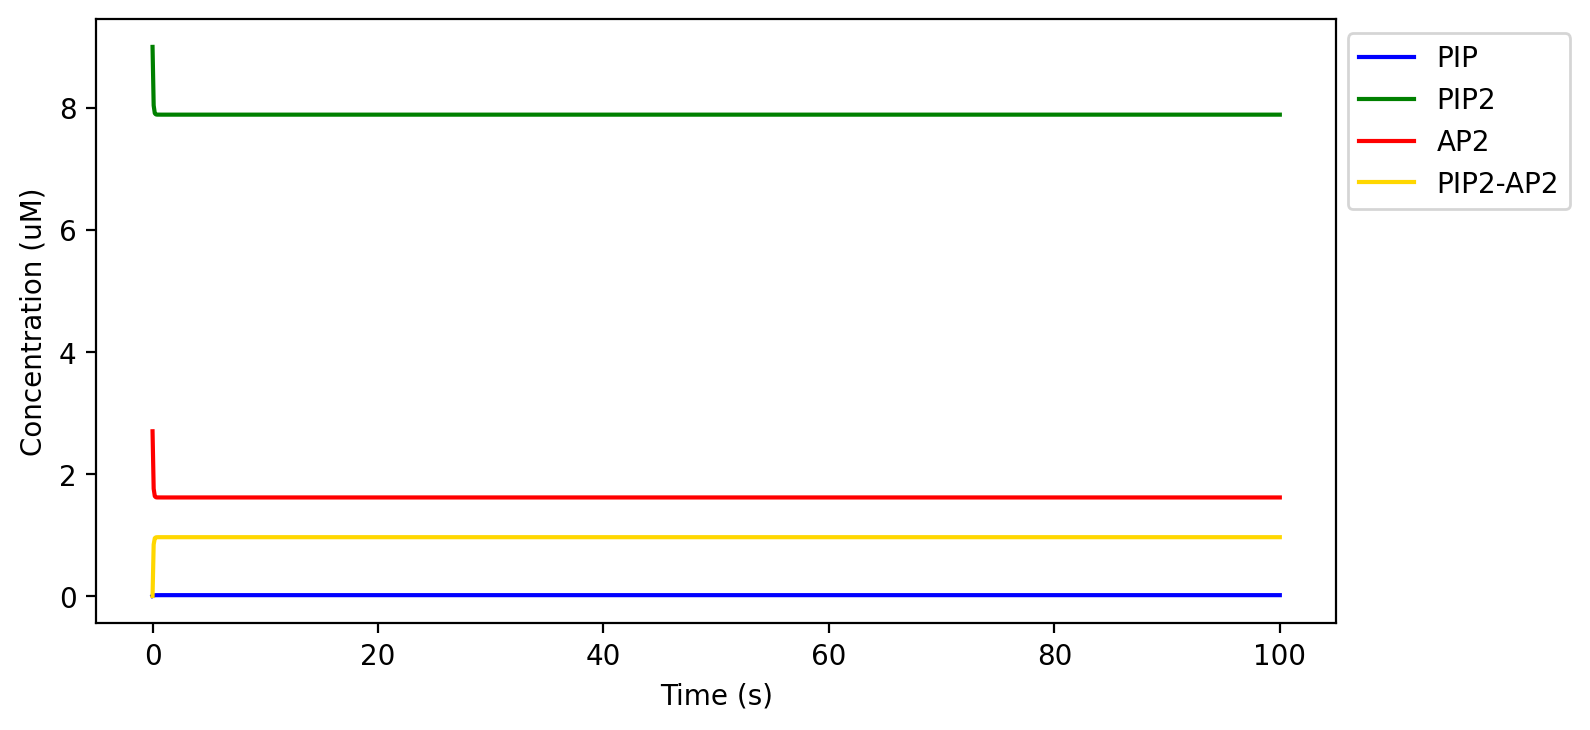

1
ka7 < ka2 < ka4 < ka1 < ka3 < 
kb1 < kb4 < kb3 < kb2 < kb7 < 
kcat1 < kcat7 < 
Kd3 < Km1 < Kd4 < Kd2 < Km7 < 

NERDSS parameters

['ka1: 0.5023797589135113 nm^3/us', 'kb1: 27.477450898543367 s^-1', 'kcat1: 4.035905489243818 s^-1', 'ka2: 0.2915540162339119 nm^3/us', 'kb2: 517.6912403930683 s^-1', 'ka3: 32.285526426687916 nm^3/us', 'kb3: 264.04023116377186 s^-1', 'ka4: 0.33452787198488393 nm^3/us', 'kb4: 97.07719896204752 s^-1', 'ka7: 0.030769694491200577 nm^3/us', 'kb7: 761.802549283869 s^-1', 'kcat7: 162.51366487048992 s^-1', 'sigma: 0.5']

Waterbox dimensions

[715, 715, 978]

ODE test parameters

[0.0010047595178270226, 27.477450898543367, 4.035905489243818, 0.0005831080324678238, 517.6912403930683, 0.06457105285337583, 264.04023116377186, 0.0006690557439697678, 97.07719896204752, 6.153938898240116e-05, 761.802549283869, 162.51366487048992, 488.8926291523155, 0.0, 2710.3500000000004, 180.69, 240.92000000000004, 0.0, 813.105, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Number of viable points: 1


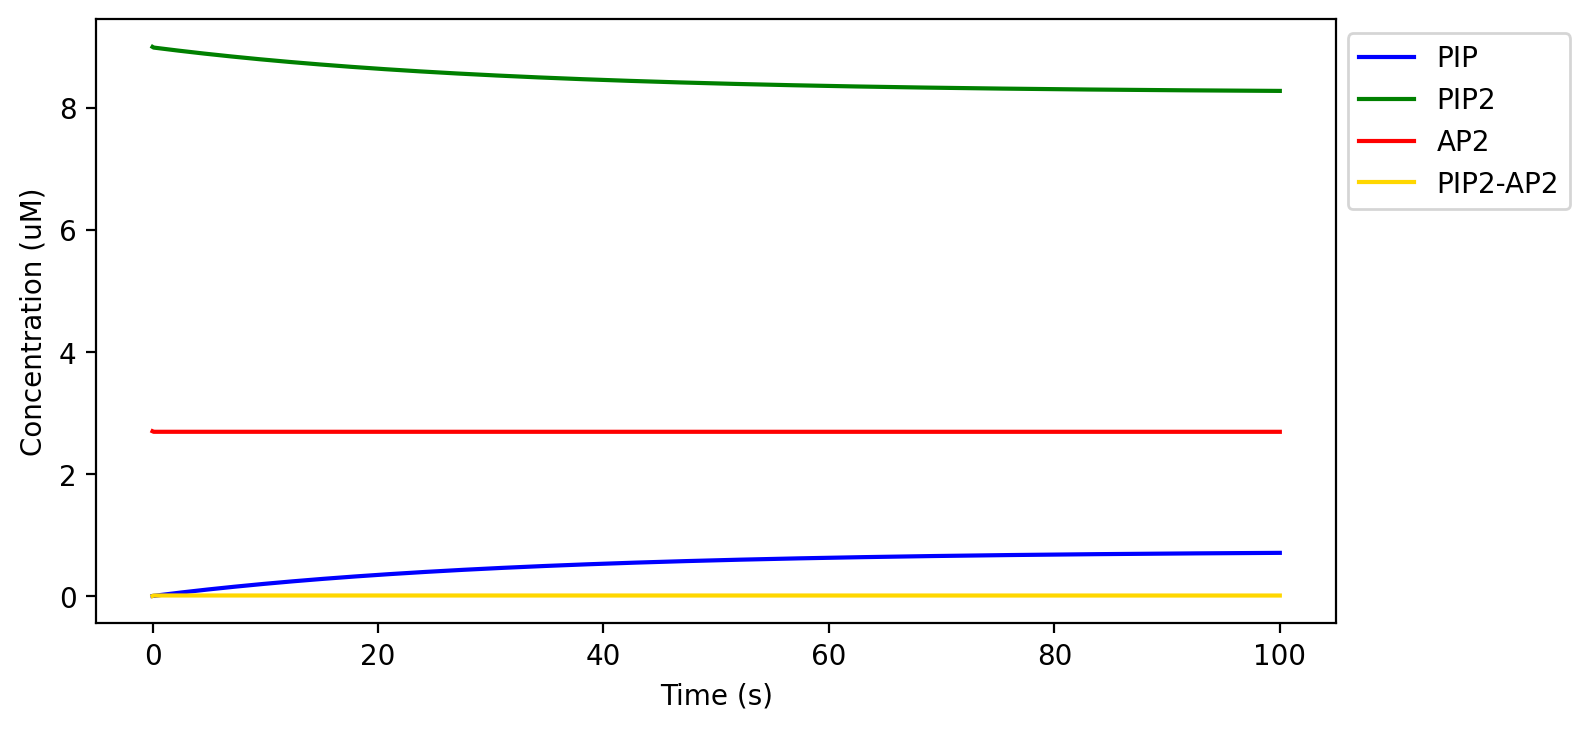

2
ka1 < ka2 < ka7 < ka4 < ka3 < 
kb4 < kb1 < kb7 < kb3 < kb2 < 
kcat7 < kcat1 < 
Kd4 < Kd3 < Km7 < Kd2 < Km1 < 

NERDSS parameters

['ka1: 0.24385517129349177 nm^3/us', 'kb1: 25.884070675623697 s^-1', 'kcat1: 96.03660697461694 s^-1', 'ka2: 1.022823031687274 nm^3/us', 'kb2: 150.49775037189525 s^-1', 'ka3: 135.18736191371377 nm^3/us', 'kb3: 43.39381692216628 s^-1', 'ka4: 1.6605390671738467 nm^3/us', 'kb4: 0.3068101744794952 s^-1', 'ka7: 1.3148441480043422 nm^3/us', 'kb7: 40.37560346925339 s^-1', 'kcat7: 46.952493160738534 s^-1', 'sigma: 0.5']

Waterbox dimensions

[577, 577, 1500]

ODE test parameters

[0.0004877103425869835, 25.884070675623697, 96.03660697461694, 0.002045646063374548, 150.49775037189525, 0.27037472382742755, 43.39381692216628, 0.0033210781343476934, 0.3068101744794952, 0.002629688296008685, 40.37560346925339, 46.952493160738534, 750.0, 0.0, 2710.3500000000004, 180.69, 240.92000000000004, 0.0, 813.105, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Number of viable points: 317
[ True]
Co

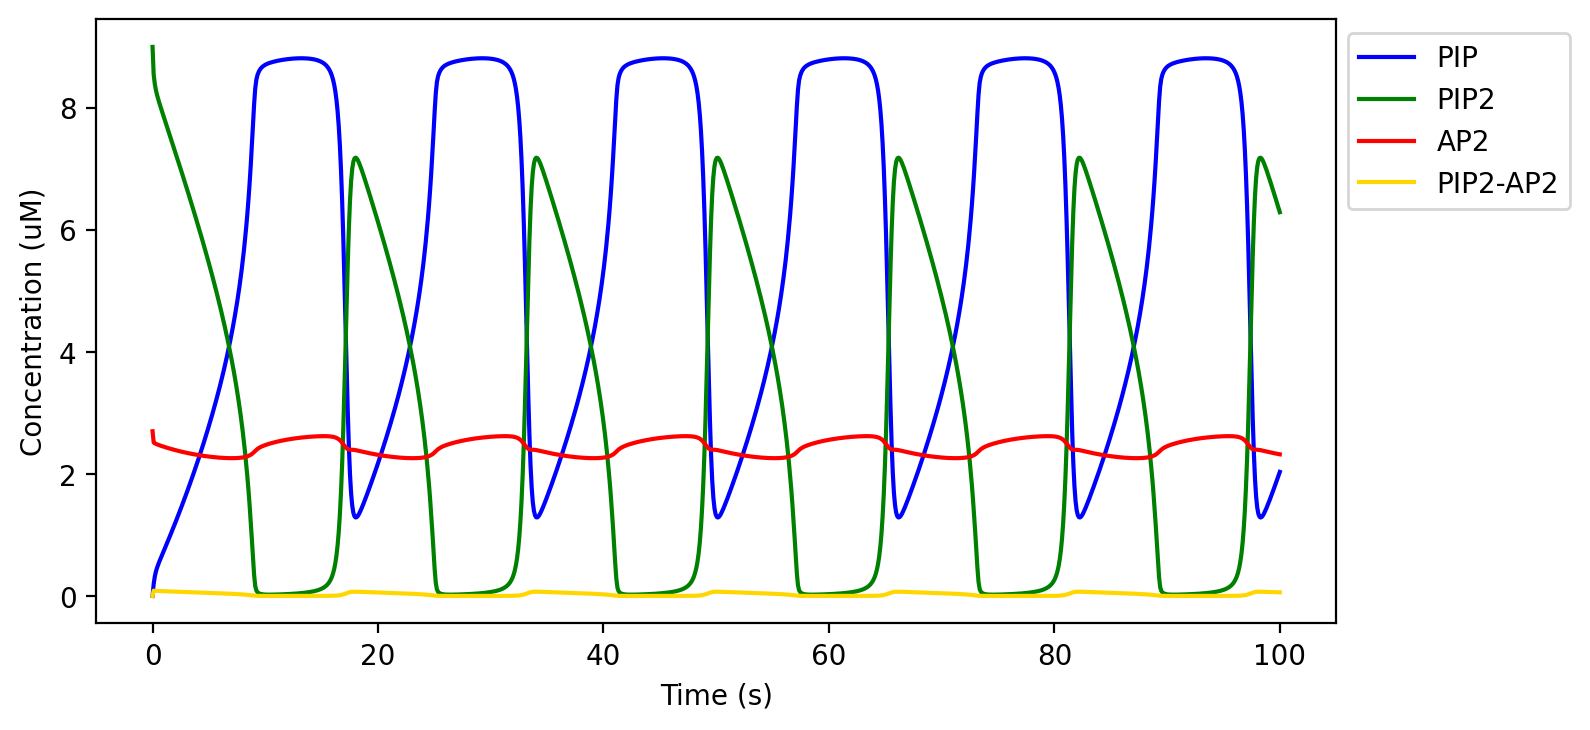

3
ka1 < ka4 < ka7 < ka2 < ka3 < 
kb4 < kb7 < kb3 < kb1 < kb2 < 
kcat7 < kcat1 < 
Kd4 < Kd3 < Kd2 < Km7 < Km1 < 

NERDSS parameters

['ka1: 0.31052953832320584 nm^3/us', 'kb1: 40.15982685483281 s^-1', 'kcat1: 65.4921086487074 s^-1', 'ka2: 1.6605390671738467 nm^3/us', 'kb2: 49.94283141365582 s^-1', 'ka3: 136.78469744078075 nm^3/us', 'kb3: 31.27225366472393 s^-1', 'ka4: 0.8159741716887512 nm^3/us', 'kb4: 0.10596344748646773 s^-1', 'ka7: 1.5084994517276389 nm^3/us', 'kb7: 23.877302904727856 s^-1', 'kcat7: 36.57982238939517 s^-1', 'sigma: 0.5']

Waterbox dimensions

[577, 577, 1500]

ODE test parameters

[0.0006210590766464116, 40.15982685483281, 65.4921086487074, 0.0033210781343476934, 49.94283141365582, 0.2735693948815615, 31.27225366472393, 0.0016319483433775025, 0.10596344748646773, 0.003016998903455278, 23.877302904727856, 36.57982238939517, 750.0, 0.0, 2710.3500000000004, 180.69, 240.92000000000004, 0.0, 813.105, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Number of viable points: 6553
[ True]
Cost

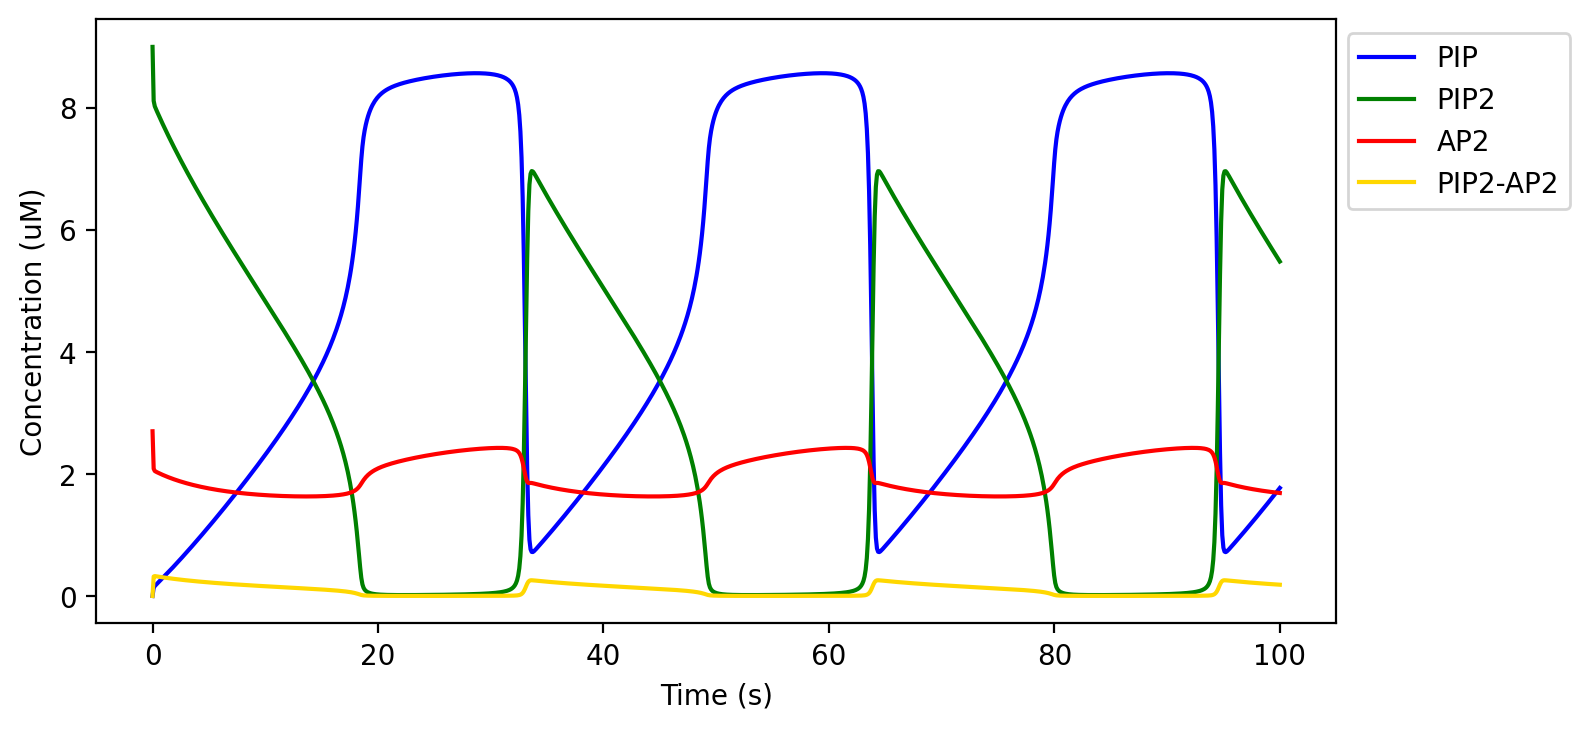

4
ka1 < ka4 < ka2 < ka7 < ka3 < 
kb4 < kb2 < kb7 < kb1 < kb3 < 
kcat7 < kcat1 < 
Kd4 < Kd3 < Kd2 < Km7 < Km1 < 

NERDSS parameters

['ka1: 0.2625247405301497 nm^3/us', 'kb1: 22.06536110666815 s^-1', 'kcat1: 167.45687395716695 s^-1', 'ka2: 1.1449588052338273 nm^3/us', 'kb2: 4.821571977275756 s^-1', 'ka3: 88.56111958991059 nm^3/us', 'kb3: 171.72405336350735 s^-1', 'ka4: 0.6040624706179878 nm^3/us', 'kb4: 0.16680744754092539 s^-1', 'ka7: 1.3183488076571819 nm^3/us', 'kb7: 17.60245801955043 s^-1', 'kcat7: 34.73552075215479 s^-1', 'sigma: 0.5']

Waterbox dimensions

[625, 625, 1280]

ODE test parameters

[0.0005250494810602993, 22.06536110666815, 167.45687395716695, 0.0022899176104676545, 4.821571977275756, 0.1771222391798212, 171.72405336350735, 0.0012081249412359755, 0.16680744754092539, 0.002636697615314364, 17.60245801955043, 34.73552075215479, 639.7720351648688, 0.0, 2710.3500000000004, 180.69, 240.92000000000004, 0.0, 813.105, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Number of viable points: 130

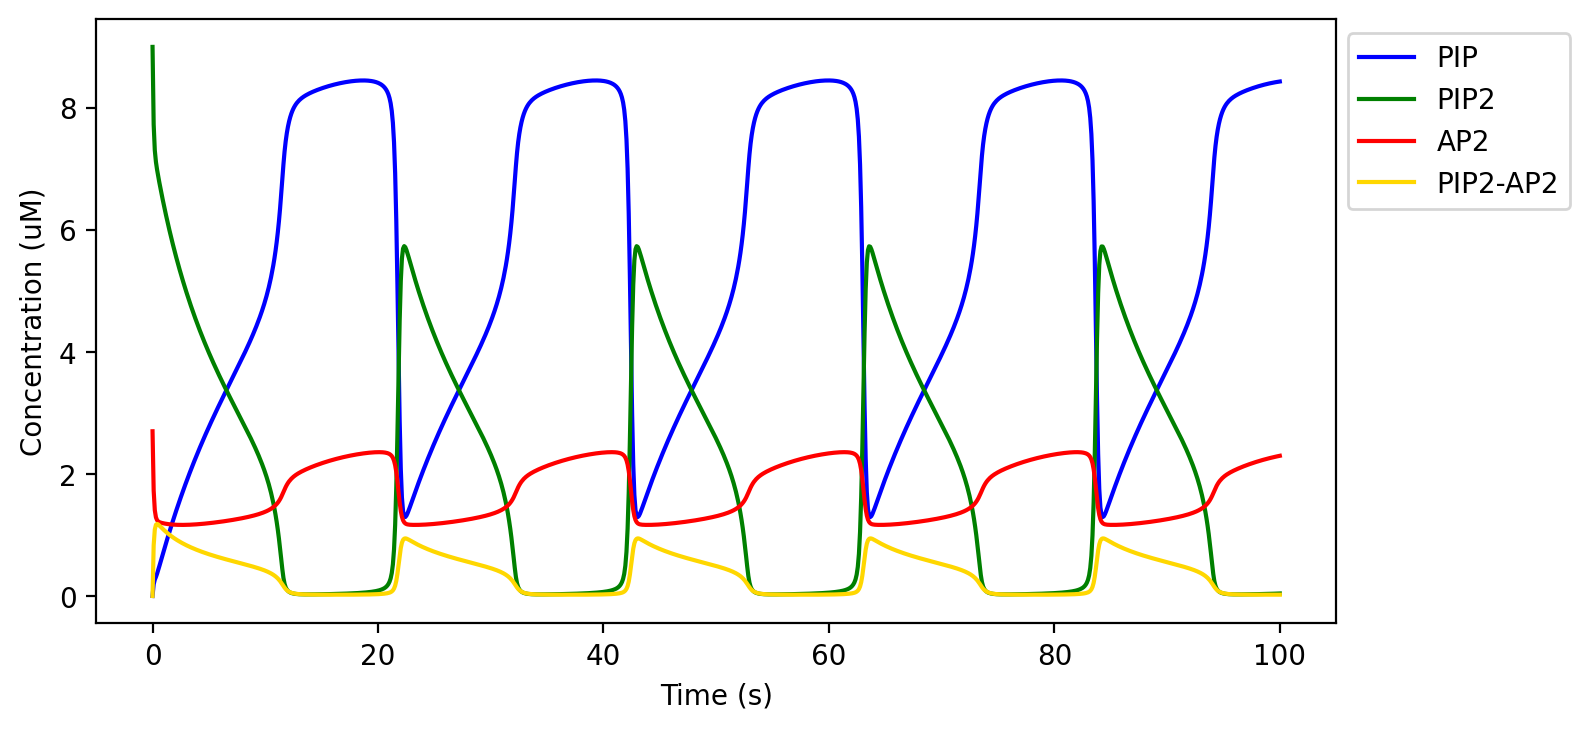

5
ka1 < ka4 < ka7 < ka2 < ka3 < 
kb4 < kb2 < kb7 < kb1 < kb3 < 
kcat7 < kcat1 < 
Kd4 < Kd2 < Kd3 < Km7 < Km1 < 

NERDSS parameters

['ka1: 0.21736267766419382 nm^3/us', 'kb1: 42.264546422181894 s^-1', 'kcat1: 97.6234747773745 s^-1', 'ka2: 1.6605390671738467 nm^3/us', 'kb2: 1.9817267031161996 s^-1', 'ka3: 57.754321172014706 nm^3/us', 'kb3: 283.7823677923157 s^-1', 'ka4: 0.4843158065820003 nm^3/us', 'kb4: 0.13741256901531282 s^-1', 'ka7: 1.602792471585026 nm^3/us', 'kb7: 13.634907454616515 s^-1', 'kcat7: 22.055889205677442 s^-1', 'sigma: 0.5']

Waterbox dimensions

[577, 577, 1500]

ODE test parameters

[0.00043472535532838765, 42.264546422181894, 97.6234747773745, 0.0033210781343476934, 1.9817267031161996, 0.11550864234402941, 283.7823677923157, 0.0009686316131640005, 0.13741256901531282, 0.003205584943170052, 13.634907454616515, 22.055889205677442, 750.0, 0.0, 2710.3500000000004, 180.69, 240.92000000000004, 0.0, 813.105, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Number of viable points: 17987
[ Tr

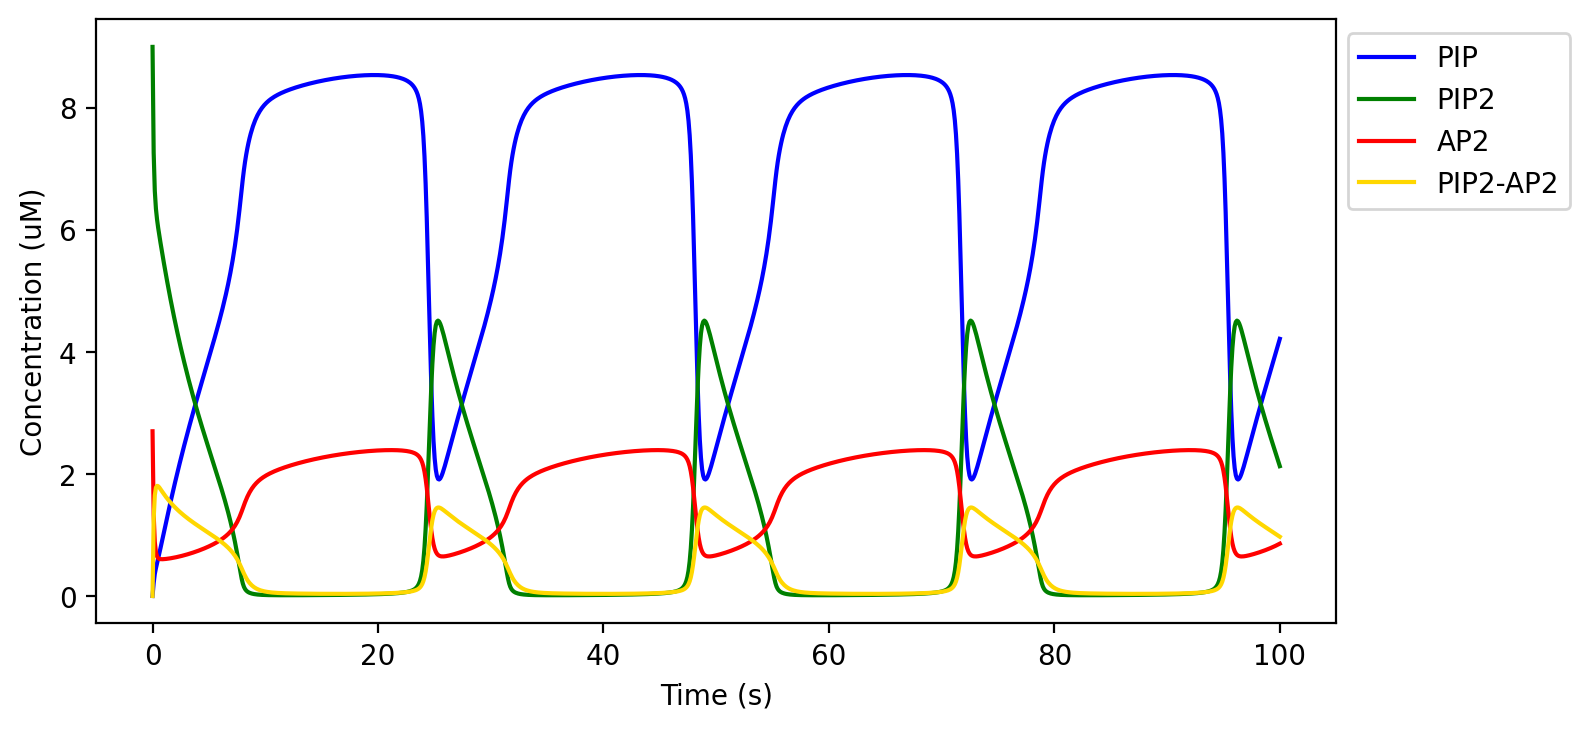

6
ka1 < ka4 < ka2 < ka7 < ka3 < 
kb4 < kb2 < kb7 < kb1 < kb3 < 
kcat7 < kcat1 < 
Kd4 < Kd2 < Kd3 < Km7 < Km1 < 

NERDSS parameters

['ka1: 0.32707732910602 nm^3/us', 'kb1: 44.112364245952115 s^-1', 'kcat1: 118.73102737685416 s^-1', 'ka2: 1.6605390671738467 nm^3/us', 'kb2: 2.2770478975004083 s^-1', 'ka3: 53.39035441085247 nm^3/us', 'kb3: 361.6263759099068 s^-1', 'ka4: 0.3349665923939484 nm^3/us', 'kb4: 0.1429878074256888 s^-1', 'ka7: 1.6605390671738467 nm^3/us', 'kb7: 13.618033235124555 s^-1', 'kcat7: 21.672073009967573 s^-1', 'sigma: 0.5']

Waterbox dimensions

[633, 633, 1249]

ODE test parameters

[0.00065415465821204, 44.112364245952115, 118.73102737685416, 0.0033210781343476934, 2.2770478975004083, 0.10678070882170494, 361.6263759099068, 0.0006699331847878968, 0.1429878074256888, 0.0033210781343476934, 13.618033235124555, 21.672073009967573, 624.5616967208445, 0.0, 2710.3500000000004, 180.69, 240.92000000000004, 0.0, 813.105, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Number of viable points: 2

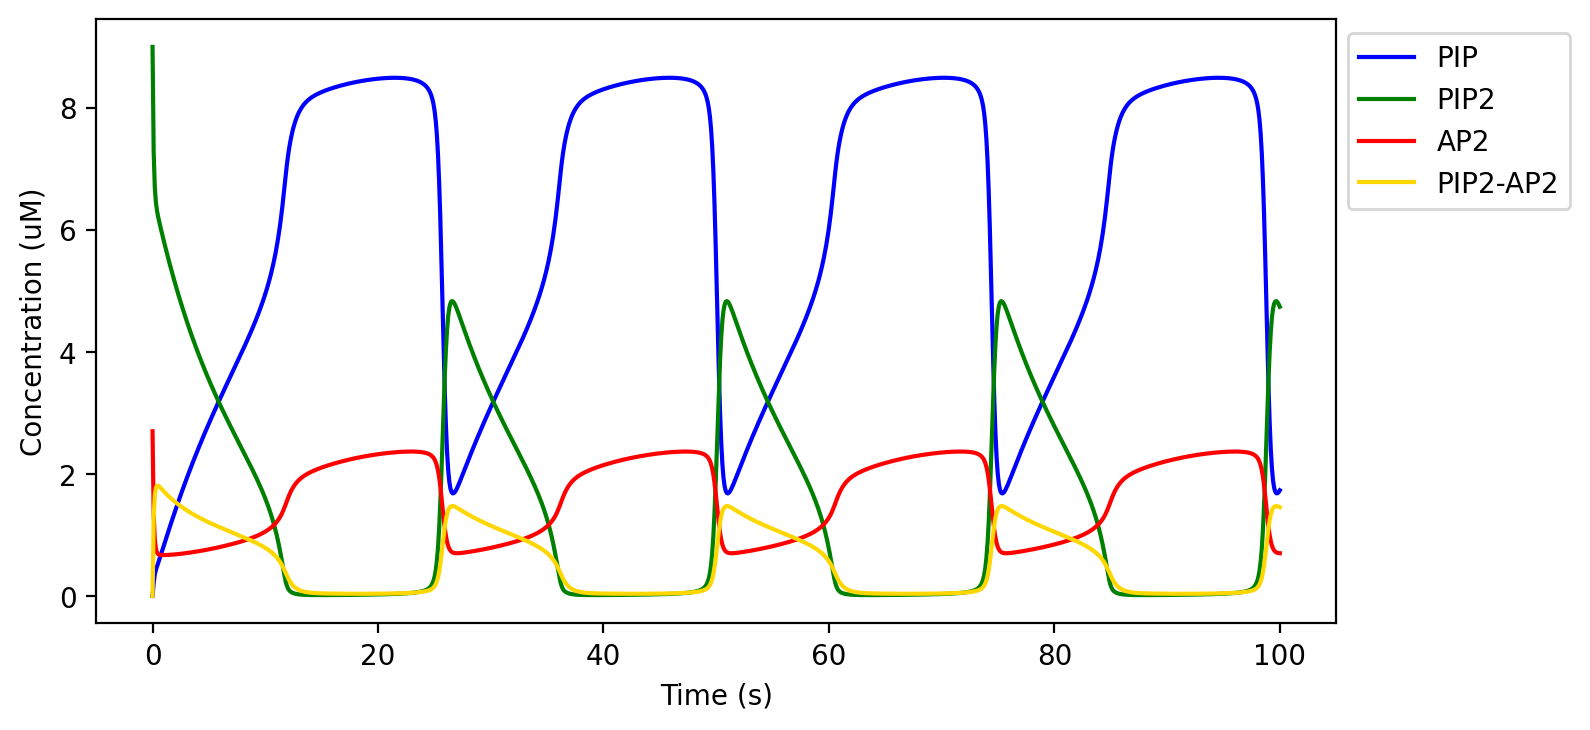

7
ka4 < ka1 < ka2 < ka7 < ka3 < 
kb4 < kb2 < kb7 < kb1 < kb3 < 
kcat7 < kcat1 < 
Kd2 < Kd4 < Kd3 < Km7 < Km1 < 

NERDSS parameters

['ka1: 0.21181766712459774 nm^3/us', 'kb1: 44.735740698769945 s^-1', 'kcat1: 55.796947570241784 s^-1', 'ka2: 1.6605390671738467 nm^3/us', 'kb2: 1.2068791493071034 s^-1', 'ka3: 40.89861852424175 nm^3/us', 'kb3: 314.1127722588568 s^-1', 'ka4: 0.20459126433071623 nm^3/us', 'kb4: 0.2568566755564171 s^-1', 'ka7: 1.6605390671738467 nm^3/us', 'kb7: 6.758505450101436 s^-1', 'kcat7: 13.743444372989583 s^-1', 'sigma: 0.5']

Waterbox dimensions

[586, 586, 1455]

ODE test parameters

[0.0004236353342491955, 44.735740698769945, 55.796947570241784, 0.0033210781343476934, 1.2068791493071034, 0.08179723704848349, 314.1127722588568, 0.00040918252866143246, 0.2568566755564171, 0.0033210781343476934, 6.758505450101436, 13.743444372989583, 727.5028345820471, 0.0, 2710.3500000000004, 180.69, 240.92000000000004, 0.0, 813.105, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Number of viable poin

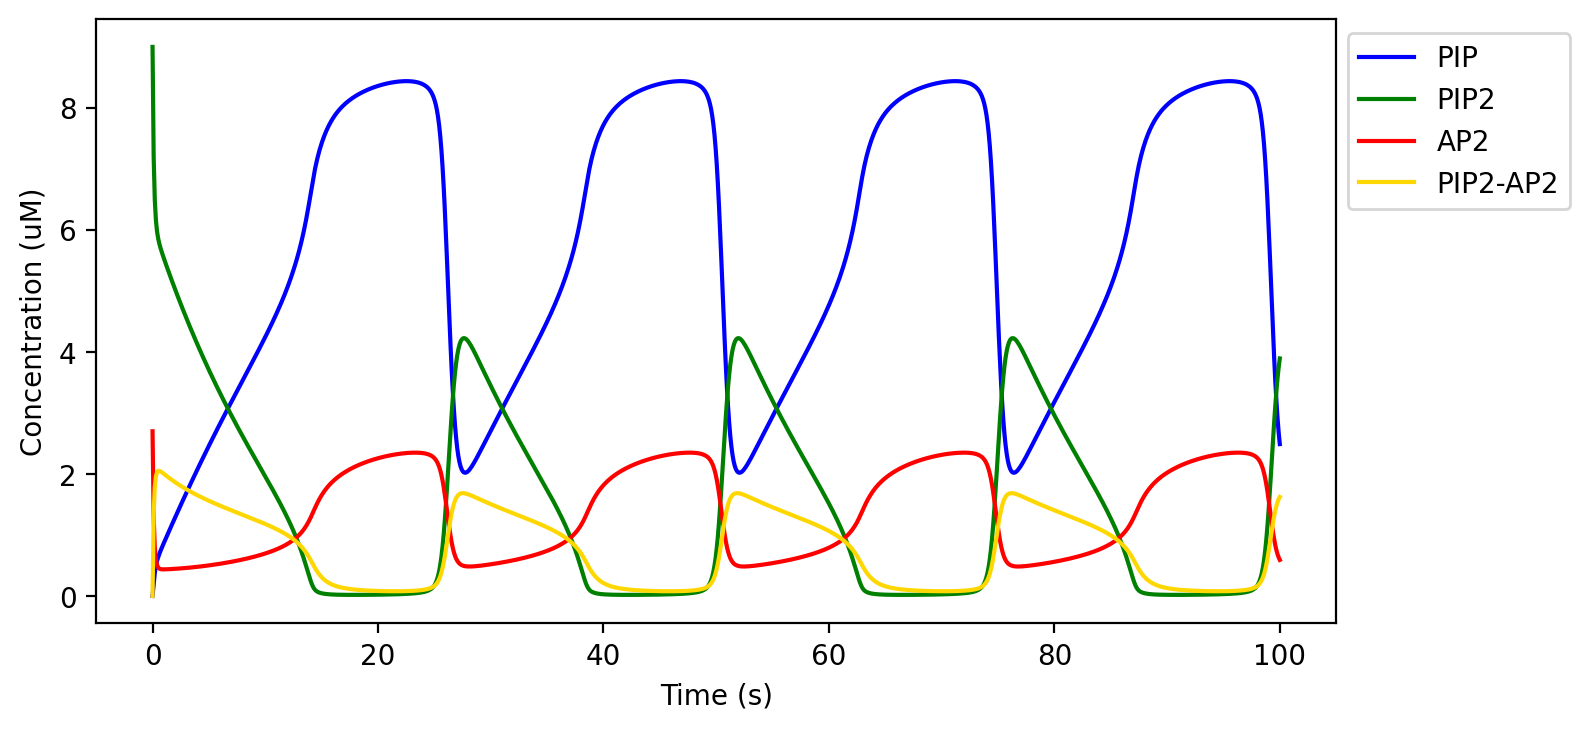

8
ka1 < ka4 < ka2 < ka7 < ka3 < 
kb4 < kb2 < kb7 < kb1 < kb3 < 
kcat7 < kcat1 < 
Kd2 < Kd4 < Km7 < Kd3 < Km1 < 

NERDSS parameters

['ka1: 0.1407559911992982 nm^3/us', 'kb1: 46.202424314369544 s^-1', 'kcat1: 61.56365637766066 s^-1', 'ka2: 1.6605390671738467 nm^3/us', 'kb2: 0.9155700507046306 s^-1', 'ka3: 38.37794599775332 nm^3/us', 'kb3: 500 s^-1', 'ka4: 0.24051743091856712 nm^3/us', 'kb4: 0.26818961246836476 s^-1', 'ka7: 1.6605390671738467 nm^3/us', 'kb7: 3.151730643517074 s^-1', 'kcat7: 6.3697224417623435 s^-1', 'sigma: 0.5']

Waterbox dimensions

[617, 617, 1314]

ODE test parameters

[0.0002815119823985964, 46.202424314369544, 61.56365637766066, 0.0033210781343476934, 0.9155700507046306, 0.07675589199550664, 500, 0.00048103486183713424, 0.26818961246836476, 0.0033210781343476934, 3.151730643517074, 6.3697224417623435, 656.9542239796219, 0.0, 2710.3500000000004, 180.69, 240.92000000000004, 0.0, 813.105, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Number of viable points: 33084
[ True]
Cost: [1.24

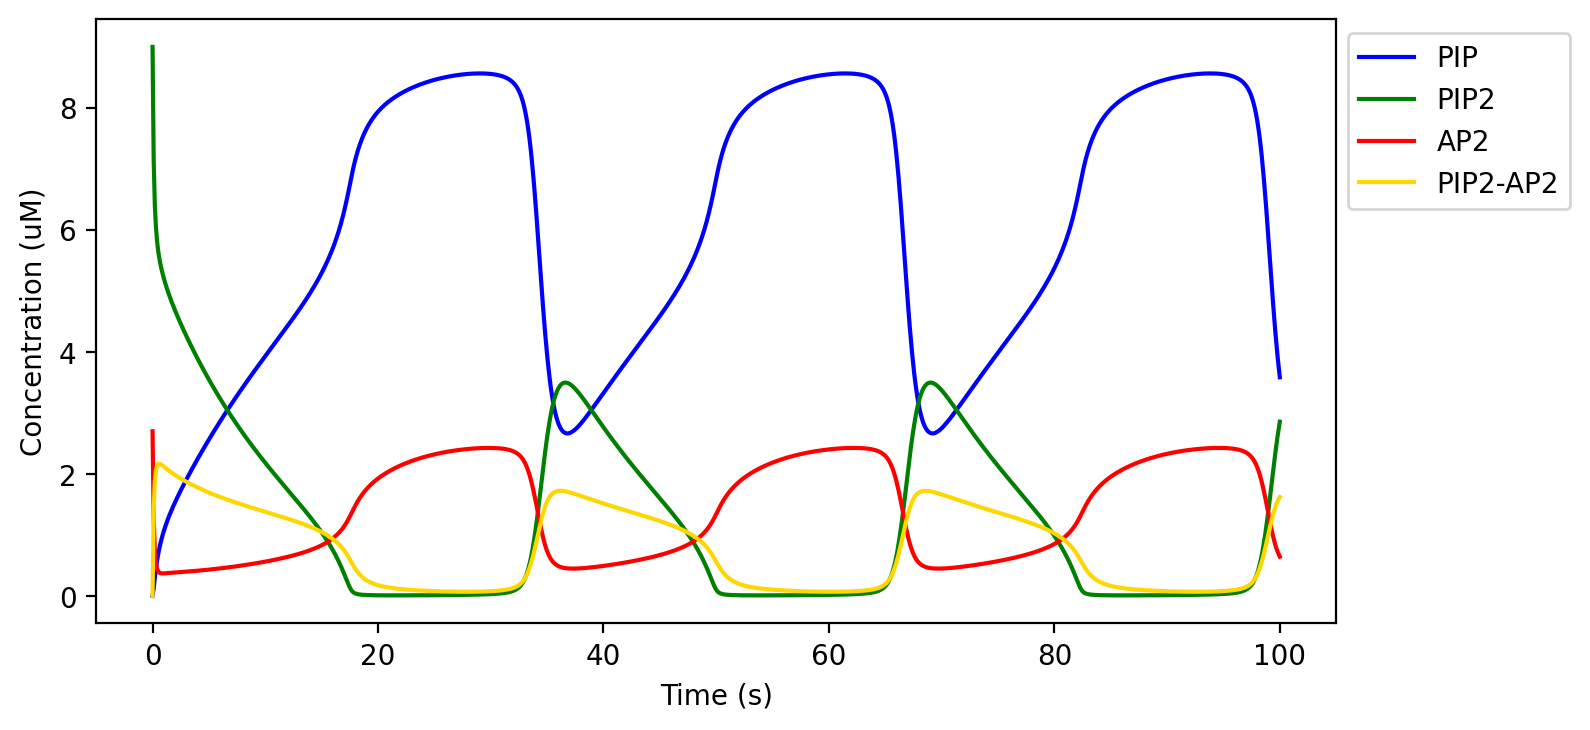

9
ka1 < ka4 < ka2 < ka7 < ka3 < 
kb4 < kb2 < kb7 < kb1 < kb3 < 
kcat7 < kcat1 < 
Kd2 < Kd4 < Kd3 < Km7 < Km1 < 

NERDSS parameters

['ka1: 0.044046167432806246 nm^3/us', 'kb1: 93.34048653685286 s^-1', 'kcat1: 80.79826181822907 s^-1', 'ka2: 1.6605390671738467 nm^3/us', 'kb2: 0.776633691215805 s^-1', 'ka3: 44.29885616542299 nm^3/us', 'kb3: 251.86750171885734 s^-1', 'ka4: 0.1825962423767555 nm^3/us', 'kb4: 0.13559405400533742 s^-1', 'ka7: 1.6605390671738467 nm^3/us', 'kb7: 5.687946875791619 s^-1', 'kcat7: 4.728957960944282 s^-1', 'sigma: 0.5']

Waterbox dimensions

[577, 577, 1500]

ODE test parameters

[8.809233486561249e-05, 93.34048653685286, 80.79826181822907, 0.0033210781343476934, 0.776633691215805, 0.08859771233084598, 251.86750171885734, 0.000365192484753511, 0.13559405400533742, 0.0033210781343476934, 5.687946875791619, 4.728957960944282, 750.0, 0.0, 2710.3500000000004, 180.69, 240.92000000000004, 0.0, 813.105, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Number of viable points: 37507
[ True]


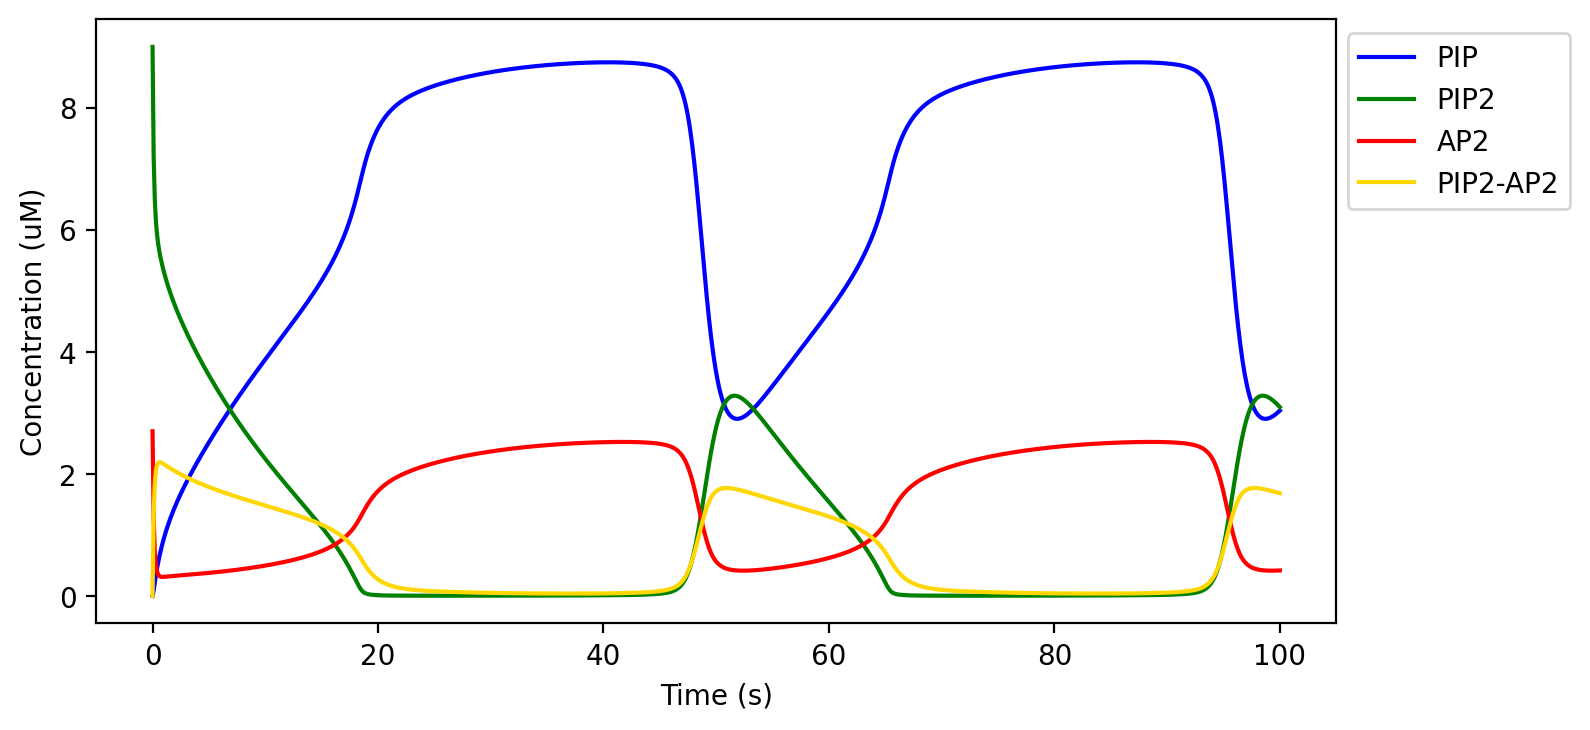

Number of viable points: 37507
Iteration: 1
Label: 0
Iter: 1
Variance scaling factor: 3.8
1000
2000
3000
Number of viable points: 882
Clustering, insufficient number of points
Clustering set0
1
2
Optimal number of clusters: 2
Iteration: 2
Label: 00
Iter: 1
Variance scaling factor: 3.8
1000
2000
3000
Number of viable points: 921
Clustering, insufficient number of points
Label: 01
Iter: 1
Variance scaling factor: 3.8
1000
2000
3000
4000
5000
Number of viable points: 2866
Clustering set00
1
2
Optimal number of clusters: 2
Iteration: 3
Label: 01
Iter: 2
Variance scaling factor: 3.5999999999999996
1000
2000
3000
4000
5000
6000
Number of viable points: 2556
Label: 000
Iter: 1
Variance scaling factor: 3.8
1000
2000
3000
4000
5000
6000
Number of viable points: 3591
Label: 001
Iter: 1
Variance scaling factor: 3.8
1000
2000
3000
4000
Number of viable points: 1478
Iteration: 4
Label: 01
Iter: 3
Variance scaling factor: 3.3999999999999995
1000
2000
3000
4000
Number of viable points: 1678
Label: 00

<Figure size 432x288 with 0 Axes>

In [33]:
filename =  os.path.join(".", "NewAllLp")  
print(filename)   
model = Oscillator(parameter_values, np.array(["ka1", "kb1", "kcat1", "ka2", "kb2", "ka3", "kb3", "ka4","kb4","ka7","kb7","kcat7",'VA']), np.array([0,9,0.6,0.8,0,2.7,0,0,0,0,0,0]), mode=1)  #[0,3,0.2,0.3,0,0.9,0,0,0,0,0,0]
solver = Solver(model, name = 'NewAllLp')         
solver.run(filename) 

## Loop to find viable initial conditions

In [12]:
for i in np.linspace(1,10,100):
    filename =  os.path.join(".", f"smAllLp{i}")  
    initial_conditions = [0,i,0.2,0.3,0,0.6,0,0,0,0,0,0]
    nonviable_initials = []  
    model = Oscillator(parameter_values, np.array(["ka1", "kb1", "kcat1", "ka2", "kb2", "ka3", "kb3", "ka4","kb4","ka7","kb7","kcat7",'VA']), np.array(initial_conditions), mode=1)  #[0,3,0.2,0.3,0,0.9,0,0,0,0,0,0]
    solver = Solver(model, name = f'smAllLp{i}', volume = 0.5, writeparms=False, verbose=False)         
    if solver.run(filename) == None:
        nonviable_initials.append(initial_conditions)

nonviable_initials

/home/local/WIN/jfisch27/miniconda3/envs/oscillations/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/local/WIN/jfisch27/miniconda3/envs/oscillations/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Candidate' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


0
1
2
3
4
5
6
7
8
9
Number of viable points: 0
No viable points found!
0
1
2
3
4
5
6
7
8
9
Number of viable points: 0
No viable points found!
0
1
2
3
4
5
6
7
8
9
Number of viable points: 0
No viable points found!
0
1
2
3
4
5
6
7
8
9
Number of viable points: 0
No viable points found!
0
1
2
3
4
5
6
7
8
9
Number of viable points: 0
No viable points found!
0
1
2
3
4
5
6
7
8
9
Number of viable points: 400
Iteration: 1
Label: 0
Iter: 1
Variance scaling factor: 3.8
1000
2000
3000
4000
5000
6000
7000
8000
Number of viable points: 722
Iteration: 2
Label: 0
Iter: 2
Variance scaling factor: 3.5999999999999996
1000
2000
3000
4000
5000
6000
7000
8000
9000
Number of viable points: 964
Iteration: 3
Label: 0
Iter: 3
Variance scaling factor: 3.3999999999999995
1000
2000
3000
4000
5000
6000
7000
Number of viable points: 673
Iteration: 4
Label: 0
Iter: 4
Variance scaling factor: 3.1999999999999993
1000
2000
3000
4000
5000
6000
7000
Number of viable points: 631
Iteration: 5
Label: 0
Iter: 5
Variance scali

/home/local/WIN/jfisch27/miniconda3/envs/oscillations/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/local/WIN/jfisch27/miniconda3/envs/oscillations/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Candidate' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


0
1
2
3
4
5
6
7
8
9
Number of viable points: 0
No viable points found!
0
1
2
3
4
5
6
7
8
9
Number of viable points: 0
No viable points found!
0
1
2
3
4
5
6
7
8
9
Number of viable points: 3385
Iteration: 1
Label: 0
Iter: 1
Variance scaling factor: 3.8
1000
2000
3000
4000
5000
Number of viable points: 464
Iteration: 2
Label: 0
Iter: 2
Variance scaling factor: 3.5999999999999996
1000
2000
3000
4000
5000
Number of viable points: 321
Iteration: 3
Label: 0
Iter: 3
Variance scaling factor: 3.3999999999999995
1000
2000
3000
4000
Number of viable points: 227
Iteration: 4
Label: 0
Iter: 4
Variance scaling factor: 3.1999999999999993
1000
2000
3000
4000
Number of viable points: 276
Iteration: 5
Label: 0
Iter: 5
Variance scaling factor: 2.999999999999999
1000
2000
3000
4000
5000
Number of viable points: 321
Iteration: 6
Label: 0
Iter: 6
Variance scaling factor: 2.799999999999999
1000
2000
3000
4000
5000
Number of viable points: 422
Iteration: 7
Label: 0
Iter: 7
Variance scaling factor: 2.5999999999

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

## Centerpoints of each cluster

In [11]:
def full_converter(solver, sample, ode = False):
    new_sample = []
    for i,val in enumerate(sample): 
        if i == 0 or i ==3 or i ==5 or i==7 or i==9:
            new_sample.append(solver.rate_converter(val, ode))
        elif i==1 or i==2 or i==4 or i==6 or i==8 or i==10 or i==11:
            new_sample.append(val)
        elif i==12 and ode==True:
            new_sample.append(val/(0.002))
        else:
            new_sample.append(val)
    new_sample.extend(solver.copynumbers)
        
    return new_sample

In [13]:
ode_dict = {}
for i, point in enumerate(solver.centerpoints):
    nerdss_point = full_converter(solver,point)
    waterbox = solver.waterbox(nerdss_point[12])
    solver.write_parms(nerdss_point,waterbox, f'Center{i}')
    ode_dict[i] = full_converter(solver,point,ode=True)
    

In [14]:
ode_dict[0]

KeyError: 0

In [39]:
full_converter(solver,solver.centerpoints[0])

[0.13170025530954158,
 43.554791096756745,
 61.27678775536862,
 1.6605390671738467,
 3.5802008552052027,
 104.53136285275617,
 411.6059385064102,
 0.1634810053430519,
 0.7535040872309138,
 1.6605390671738467,
 17.402538471956877,
 19.17270732908545,
 1.3340378234145018,
 0.0,
 2710.3500000000004,
 180.69,
 240.92000000000004,
 0.0,
 813.105,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

# Load all viable points

In [102]:
allViablePoints = np.empty([1,13])
for filepath in glob.iglob('/home/local/WIN/jfisch27/Desktop/Oscillator/Python/2022_simple_system/2d_troubleshooting/PEPE/8-16-22/smAllLp_*ViableSet_Iter10.p'):
    viablePoints = pickle.load(open(filepath,'rb'))
    allViablePoints = np.vstack((allViablePoints,viablePoints))


## Load one set of points

In [11]:
viablePoints = pickle.load(open('/home/local/WIN/jfisch27/Desktop/Oscillator/Python/2022_simple_system/2d_troubleshooting/PEPE/8-9-22/AllLp_Region000ViableSet_Iter10.p','rb'))

# Analysis

## Parametric relationships

In [110]:
import collections

kadic_counts = [[] for i in range(5)]
kbdic_counts = [[] for i in range(5)]
kcatdic_counts = [[] for i in range(2)]
KDdic_counts = [[] for i in range(5)]
counts = [kadic_counts, kbdic_counts, kcatdic_counts, KDdic_counts]

for rdm_ind in allViablePoints:

    kadic = {'ka1':rdm_ind[0],'ka2':rdm_ind[3],'ka3':rdm_ind[5],'ka4':rdm_ind[7],'ka7':rdm_ind[9]}
    kbdic = {'kb1':rdm_ind[1],'kb2':rdm_ind[4],'kb3':rdm_ind[6],'kb4':rdm_ind[8],'kb7':rdm_ind[10]}
    kcatdic = {'kcat1':rdm_ind[2],'kcat7':rdm_ind[11]}
    KDdic = {'Km1':(rdm_ind[1]+rdm_ind[2])/rdm_ind[0],'Kd2':rdm_ind[4]/rdm_ind[3],'Kd3':rdm_ind[6]/rdm_ind[5],'Kd4':rdm_ind[8]/rdm_ind[7],'Km7':(rdm_ind[10]+rdm_ind[11])/rdm_ind[9]}
    comparison_list = [kadic,kbdic,kcatdic,KDdic]

    for i,h in enumerate(comparison_list):
        sorted_keys = sorted(h, key=h.get)  # [1, 3, 2]
        for j,key in enumerate(sorted_keys):
            counts[i][j].append(key)

for list in counts:
    string = ""
    for par in list:
        freqs = collections.Counter(par)
        most_freq = freqs.most_common(1)[0][0]
        string += most_freq + " < "
    print(string)



ka1 < ka1 < ka2 < ka7 < ka3 < 
kb4 < kb2 < kb7 < kb1 < kb3 < 
kcat7 < kcat1 < 
Kd4 < Kd2 < Kd3 < Km7 < Km1 < 


## SSA

In [8]:
def ssa_converter(sample):
    new_sample = []
    for i,val in enumerate(sample): 
        if i == 0 or i ==3 or i ==5 or i==7 or i==9:
            new_sample.append(solver.rate_converter(val,solver.volume, True))
        elif i==1 or i==2 or i==4 or i==6 or i==8 or i==10 or i==11 or i==12:
            new_sample.append(val)
        elif i==13 or i==14 or i==15 or i==16:
            new_sample.append(solver.copynumber(val,solver.volume))
        
    return new_sample


In [10]:
plt.rcParams.update({'font.size': 12}) 

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Candidate", list, fitness=creator.FitnessMax)		
toolbox = base.Toolbox()	 
toolbox.register("candidate", Solver.generateCandidate) 
				
     
folder1 = os.path.join(".", "/Users/jonathanfischer/Desktop/Desktop - Jonathan’s MacBook Air/Oscillator/Python/2022_simple_system/2d_troubleshooting/PEPE/6-27-22")   
			



file1 =  os.path.join(folder1, "7-12_Region001ViableSet_Iter10.p")    
           

viablePoints = pickle.load(open(file1, "rb"))  
   

allViablePoints = viablePoints
pca = PCA(n_components=2)
pca.fit(allViablePoints)

model = Oscillator(parameter_values, np.array(["ka1", "kb1", "kcat1", "ka2", "kb2", "ka3", "kb3", "ka4","kb4","ka7","kb7","kcat7","VA"]), np.array([0,0,0,0,0,0,0,0,0,0,0,0]), mode=1)  

###                   ###
###  SSA simulations  ###
###                   ###  

#sample few random points from viable regions for region 2     
readFromFile = False                 

region = viablePoints    
numSamples = 9
if readFromFile:
	sampleNumbers = pickle.load(open("stochastic_samples_numbers_repressilator", "rb"))
else:
	num2 = region.shape[0]  
	sampleNumbers = np.random.choice(num2, numSamples, replace=False)   
	pickle.dump(sampleNumbers, open("stochastic_samples_numbers_repressilator", "wb+"))    
	
#plot few simulations (ode + ssa)
t = np.linspace(0, model.T, model.N)
#t = np.linspace(0, 1000, model2.N)
if readFromFile:
	samples = pickle.load(open("stochastic_samples_repressilator","rb"))     
else:	
	samples = region[sampleNumbers,:]
	pickle.dump(samples, open("stochastic_samples_repressilator", "wb+"))   
	
notWorking = samples[numSamples-3:numSamples,:] 
notWorking = np.copy(notWorking) 
notWorking[0,2] = 1 #low hill coefficient
notWorking[1,0] = 1 #low transcription 
notWorking[2,5] = 10 #high protein degradation   

allSamples = np.vstack((samples, notWorking)) 

ts_total_stochastic = [] 
Y_total_stochastic = []
t_total_ode = []
Y_total_ode = []



if readFromFile:
	t_total_ode, Y_total_ode = pickle.load(open("stochastic_simulations_repressilator", "rb"))  

plt.figure(figsize=(25,25))
for i in range(numSamples + 3): 
	print(i)  
	
	ax1=plt.subplot(4, 3, i + 1)

	ax1.set_title("Sample " + str(i + 1), fontsize=12)	 
	
	sample = allSamples[i] 
	#sample = np.ndarray.tolist(sample)
	#print(sample)
	sampleSSA = ssa_converter(sample)
	#print(sample)
	if readFromFile:
		ts = ts_total_stochastic[i]   
		Y = Y_total_stochastic[i]  
		Y_ode = Y_total_ode[i]  
		t = t_total_ode[i]  
	else:
		ts, Y = model.ssa(sampleSSA)
		#Y = Y/model.omega 
		#plt.plot(ts,Y)
		#plt.show()
		Y_ode = model.simulate(sampleSSA) 
		#plt.plot(t,Y_ode)
		#plt.show() 
		#print(sample)
		ts_total_stochastic.append(ts)
		Y_total_stochastic.append(Y) 
		t_total_ode.append(t)  
		Y_total_ode.append(Y_ode) 
	

	plt.plot(t, Y_ode[:,0], color="b", label = 'L', linestyle = "--")
	plt.plot(ts, Y[:,0], color="b")

	plt.plot(t,Y_ode[:,1], color="r", label = 'Lp', linestyle = "--")
	plt.plot(ts,Y[:,1], color="r")

	plt.plot(t,Y_ode[:,2], color="gold", label = 'K', linestyle = "--")
	plt.plot(ts,Y[:,2], color="gold")

	plt.plot(t,Y_ode[:,3], color="g", label = 'P', linestyle = "--")
	plt.plot(ts,Y[:,3], color="g")

	plt.plot(t,Y_ode[:,4], color="cyan", label = 'LK', linestyle = "--")
	plt.plot(ts,Y[:,4], color="cyan")

	plt.plot(t,Y_ode[:,5], color="black", label = 'A', linestyle = "--")
	plt.plot(ts,Y[:,5], color="black")

	plt.plot(t,Y_ode[:,6], color="indigo", label = 'LpA', linestyle = "--")
	plt.plot(ts,Y[:,6], color="indigo")

	plt.plot(t,Y_ode[:,7], color="yellow", label = 'LpAK', linestyle = "--")
	plt.plot(ts,Y[:,7], color="yellow")

	plt.plot(t,Y_ode[:,8], color="magenta", label = 'LpAP', linestyle = "--")
	plt.plot(ts,Y[:,8], color="magenta")

	plt.plot(t,Y_ode[:,9], color="deeppink", label = 'LpAPLp', linestyle = "--")
	plt.plot(ts,Y[:,9], color="deeppink")

	plt.plot(t,Y_ode[:,10], color="peru", label = 'LpAKL', linestyle = "--")
	plt.plot(ts,Y[:,10], color="peru")
	#lines = plt.plot(t, Y_ode[:,0], t, Y_ode[:,1], t, Y_ode[:,2], t, Y_ode[:,3], t, Y_ode[:,4], t, Y_ode[:,5], t, Y_ode[:,6], t, Y_ode[:,7], t, Y_ode[:,8]) #ts, Y[:,1])  
	#plt.setp(lines[0], linestyle = "-", linewidth=1.5, alpha=1, c="#15A357")
	


		
	if i == 9 or i == 10 or i == 11:
		plt.xlabel(r"Time [$h$]")    
	if i == 0 or i == 3 or i == 6 or i == 9:
		plt.ylabel('Concentration [$nM$]') 
	if i == 2:
		plt.legend(loc = 1) 
#plt.savefig("FreeKinase_time_series.png")  	
plt.show()




/home/local/WIN/jfisch27/miniconda3/envs/oscillations/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/local/WIN/jfisch27/miniconda3/envs/oscillations/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Candidate' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


FileNotFoundError: [Errno 2] No such file or directory: '/Users/jonathanfischer/Desktop/Desktop - Jonathan’s MacBook Air/Oscillator/Python/2022_simple_system/2d_troubleshooting/PEPE/6-27-22/7-12_Region001ViableSet_Iter10.p'

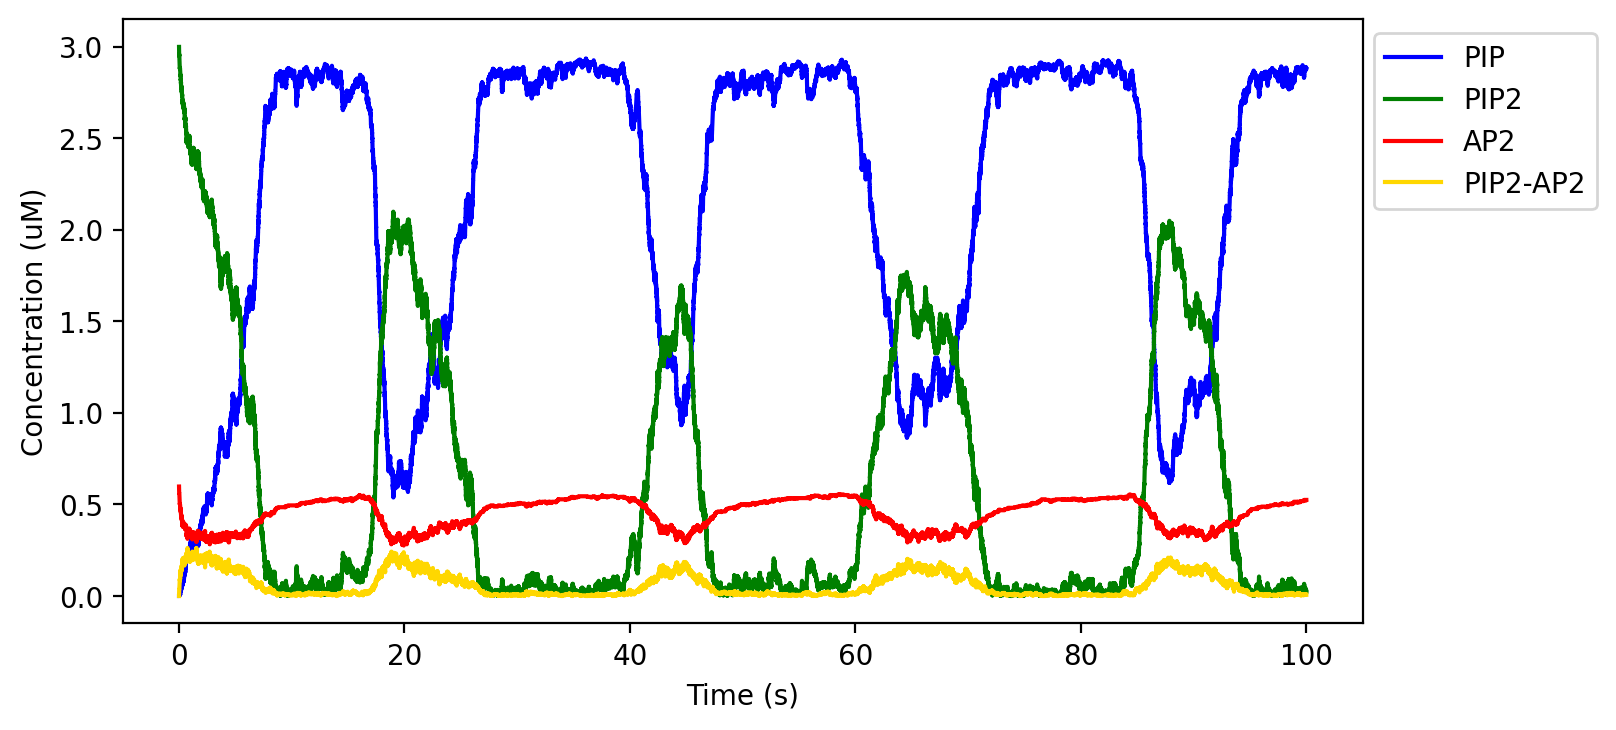

In [68]:
model.plotModel(viablePoints[3],mode = 'ssa')

In [23]:
folder1 = os.path.join(".", "/home/local/WIN/jfisch27/Desktop/Oscillator/Python/2022_simple_system/2d_troubleshooting/PEPE/6-27-22")   
			
				
file1 =  os.path.join(folder1, "7-12_Region000ViableSet_Iter10.p")    
           

viablePoints = pickle.load(open(file1, "rb"))  

model = Oscillator(parameter_values, np.array(["ka1", "kb1", "kcat1", "ka2", "kb2", "ka3", "kb3", "ka4","kb4","ka7","kb7","kcat7","VA","L","K","P","A"]), np.array([0,0,0,0,0,0,0,0,0,0,0,0]), mode=1)  

###                   ###
###  SSA simulations  ###
###                   ###  

#sample few random points from viable regions for region 2     
readFromFile = False                 

region = viablePoints    
numSamples = 9
if readFromFile:
	sampleNumbers = pickle.load(open("9_sampleNUMBERS_sensitivity_analysis", "rb"))
else:
	num2 = region.shape[0]  
	sampleNumbers = np.random.choice(num2, numSamples, replace=False)   
	pickle.dump(sampleNumbers, open("9_sampleNUMBERS_sensitivity_analysis", "wb+"))    
	
#plot few simulations (ode + ssa)
t = np.linspace(0, model.T, model.N)
#t = np.linspace(0, 1000, model2.N)
if readFromFile:
	samples = pickle.load(open("9_sample_sensitivity_analysis","rb"))     
else:	
	samples = region[sampleNumbers,:]
	pickle.dump(samples, open("9_sample_sensitivity_analysis", "wb+"))  


ranks = []
for i in samples:
	per, amp = model.getPerAmp(i, mode="ode", indx=1)
	for param in i:
		
	
	#model.plotModel(i)
	#score = model.eval(i)
	#ranks.append(score)

#sorted_ranks = sorted(ranks)
#print(sorted_ranks)

amp4.757505600875621
per10.257749636319893
0.4075532087587428
46.461228358545895
192.48041536723844
0.3920601768892479
50.814840697979555
65.97362008432951
150.1624304859262
0.5282413376053743
0.2061881104343981
0.6314043086381108
115.82067138316464
135.2811668275196
1.0903663559770937
14.774833301920747
0.5676173022403469
0.897066495085624
2.5202561502683407
amp2.2566237453434868
per8.818288182881826
0.6686075016907407
87.65562995444992
55.030403502888234
0.7954290651983659
34.441511837974744
35.88325298311454
227.94529543332513
0.7665034679670996
0.4135962036425788
0.6627648823707483
144.73525355267847
109.97638177136191
1.477525811334558
12.05846334350786
0.6286141868850638
0.4462755585694709
1.2972532223663171
amp2.220737341306991
per6.375374098568574
0.8041449517972967
28.408992254418223
176.792965529702
0.7098641398299097
42.262769727607974
47.85430180600928
237.01189285611662
0.6502296585156108
0.9917604501529635
0.9361811756515057
68.71633067968898
103.3024143629757
1.312349554

## Terrain plot

In [ ]:
Y = np.zeros([10000,3])
params = viablePoints[0]

for i in range(10000):
    Lp = np.random.uniform(0,20)
    A = np.random.uniform(0,10)
    X = [0,Lp,0.6,0.8,0,A,0,0,0,0,0,0]
    Y[i][0] = Lp
    Y[i][1] = A
    Y[i][2] = model.eval_fixedinitials(X,params)[0]

In [ ]:
fig = plt.figure(figsize = (25,15))

#ax = fig.add_subplot(121, projection = '3d')

#ax.scatter(param_range[:,2], param_range[:,4], param_range[:,0], c = param_range[:,0],cmap='viridis', linewidth=0.5)

ax = fig.add_subplot(111, projection = '3d')

ax.plot_trisurf(Y[:,1], Y[:,0], Y[:,2],
                cmap='plasma', edgecolor='none');

#ax.set_title('Terrain of Parameter Space')
ax.set_xlabel('AP2 Concentration (uM)', fontsize = '20')
ax.set_ylabel('PIP2 Concentration (uM)', fontsize = '20')
ax.set_zlabel('Oscillation Index', fontsize = '20')

# Sensativity Analysis

## Morris Method

In [9]:
def add1percent(k,plus=False,amount = 0.01):
    if plus == True:
        return k+(k*amount)
    else:
        return k-(k*amount) 

In [50]:
np.ndarray([1,10])

[array([42070., 42071., 42072., 42073., 42074., 42075., 42076., 42077.,
        42078., 42079.])]

Looping Morris

In [11]:
sens = []
t = np.linspace(0,100,num=1000)

for point in viablePoints:
    ka1,kb1,kcat1,ka2,kb2,ka3,kb3,ka4,kb4,ka7,kb7,kcat7,VA = [add1percent(i,False) for i in np.ndarray.tolist(point)]
    ka1D,kb1D,kcat1D,ka2D,kb2D,ka3D,kb3D,ka4D,kb4D,ka7D,kb7D,kcat7D,VAD = [add1percent(i,True) for i in np.ndarray.tolist(point)]

    problem = {
    'num_vars': 13,
    'names': ["ka1", "kb1", "kcat1", "ka2", "kb2", "ka3", "kb3", "ka4","kb4","ka7","kb7","kcat7","VA"],
    #'groups': ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17'],
    'bounds': [[ka1,ka1D],[kb1,kb1D],[kcat1,kcat1D],[ka2,ka2D],[kb2,kb2D],[ka3,ka3D],[kb3,kb3D],[ka4,ka4D],[kb4,kb4D],[ka7,ka7D],[kb7,kb7D],
            [kcat7,kcat7D],[VA,VAD]]
}


    morris_samples = sample(problem, N=10, num_levels=4, optimal_trajectories=None)

    Y = np.zeros([morris_samples.shape[0]])

    for i,X in enumerate(morris_samples):
        Y[i] = model.eval(X)[0]

    Si = morris.analyze(problem, morris_samples, Y, conf_level = 0.95, print_to_console=False, num_levels=4, num_resamples=100)

    masked_array = Si['mu_star']
    array = np.ndarray.__array__(masked_array)
    summed_array = np.sum(array)

    sens.append(summed_array)

    

    

In [15]:
pickle.dump(sens, open("Morris_viableSet.p", "wb+"))

In [18]:
max_mu = max(sens)
max_id = sens.index(max_mu)
max_id

949

Most robust point from Morris loop

In [19]:
max_point = viablePoints[max_id]
max_point

array([  0.48589929,  56.20368859, 121.96769715,   0.8231801 ,
        25.69694614,  59.25268754, 226.79705344,   0.79510793,
         0.47639426,   0.44625524,  45.84022186,  35.97717344,
         1.35541523,   8.75844979,   0.75789206,   0.91891967,
         2.21344433])

In [28]:
def convert_robust_point(solver,point):
    converted_point = np.delete(point,12)
    #converted_point.remove(converted_point[12])
    ka_ids = [0,3,5,7,9]
    #kb_ids = [1,4,6,8,10]
    #kcat_ids = [2,11]
    for i, num in enumerate(converted_point):
        if i in ka_ids:
            converted_point[i] = solver.rate_converter(num,solver.volume)
        elif i > 11:
            copynumber = solver.copynumber(num, solver.volume)
            converted_point[i] = round(copynumber)

    return converted_point
        
        
        

In [29]:
list(convert_robust_point(solver,max_point))

[0.8068547481859076,
 56.203688585933435,
 121.96769715373105,
 1.3669227208959471,
 25.696946136761987,
 98.39140249226364,
 226.79705343676648,
 1.3203077765011126,
 0.4763942609095989,
 0.7410242525579231,
 45.840221858248874,
 35.977173444738305,
 2638.0,
 228.0,
 277.0,
 667.0]

In [31]:
solver.waterbox(0.5,max_point[12])

[607, 607, 1355]

In [35]:
1.355/(2*0.001)

677.5

SSA of robust point

In [33]:
ssa_max_point = ssa_converter(max_point)

In [11]:
ts, Y = model.ssa(viablePoints[0],model.y0)
t = np.linspace(0,model.T,model.N)
Y_ode = model.simulate(viablePoints[0])

plt.figure(figsize=(25,25))

plt.plot(t, Y_ode[:,0], color="b", label = 'L', linestyle = "--")
plt.plot(ts, Y[:,0], color="b")

plt.plot(t,Y_ode[:,1], color="r", label = 'Lp', linestyle = "--")
plt.plot(ts,Y[:,1], color="r")

plt.plot(t,Y_ode[:,2], color="gold", label = 'K', linestyle = "--")
plt.plot(ts,Y[:,2], color="gold")

plt.plot(t,Y_ode[:,3], color="g", label = 'P', linestyle = "--")
plt.plot(ts,Y[:,3], color="g")

plt.plot(t,Y_ode[:,4], color="cyan", label = 'LK', linestyle = "--")
plt.plot(ts,Y[:,4], color="cyan")

plt.plot(t,Y_ode[:,5], color="black", label = 'A', linestyle = "--")
plt.plot(ts,Y[:,5], color="black")

plt.plot(t,Y_ode[:,6], color="indigo", label = 'LpA', linestyle = "--")
plt.plot(ts,Y[:,6], color="indigo")

plt.plot(t,Y_ode[:,7], color="yellow", label = 'LpAK', linestyle = "--")
plt.plot(ts,Y[:,7], color="yellow")

plt.plot(t,Y_ode[:,8], color="magenta", label = 'LpAP', linestyle = "--")
plt.plot(ts,Y[:,8], color="magenta")

plt.plot(t,Y_ode[:,9], color="deeppink", label = 'LpAPLp', linestyle = "--")
plt.plot(ts,Y[:,9], color="deeppink")

plt.plot(t,Y_ode[:,10], color="peru", label = 'LpAKL', linestyle = "--")
plt.plot(ts,Y[:,10], color="peru")

/tmp/ipykernel_4569/1918003742.py:454: RuntimeWarning: divide by zero encountered in double_scalars
  tau = (1.0/a0)*np.log(1.0/r1)


IndexError: index 0 is out of bounds for axis 0 with size 0

In [22]:
bounds = [0.5399439956871153,
 32.49731125365913,
 459.0713154241908,
 0.6703697205723796,
 98.55386776137301,
 66.94761309866233,
 187.88476784879947,
 0.732829082837601,
 0.5932803922080772,
 0.8833353263653272,
 79.8349667706061,
 98.51067194455857,
 1.21704450980531,
 8.973816043747753,
 0.6170991018130821,
 0.7934153177539267,
 2.6856696379362606]

ka1,kb1,kcat1,ka2,kb2,ka3,kb3,ka4,kb4,ka7,kb7,kcat7,VA,L,K,P,A = [add1percent(i,False) for i in bounds]

ka1D,kb1D,kcat1D,ka2D,kb2D,ka3D,kb3D,ka4D,kb4D,ka7D,kb7D,kcat7D,VAD,LD,KD,PD,AD = [add1percent(i,True) for i in bounds]

#ka1D, ka2D = 

In [29]:
#TINY RANGE
problem = {
    'num_vars': 17,
    'names': ["ka1", "kb1", "kcat1", "ka2", "kb2", "ka3", "kb3", "ka4","kb4","ka7","kb7","kcat7",'VA','L','K','P','A'],
    #'groups': ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17'],
    'bounds': [[ka1,ka1D],[kb1,kb1D],[kcat1,kcat1D],[ka2,ka2D],[kb2,kb2D],[ka3,ka3D],[kb3,kb3D],[ka4,ka4D],[kb4,kb4D],[ka7,ka7D],[kb7,kb7D],
            [kcat7,kcat7D],[VA,VAD],[L,LD],[K,KD],[P,PD],[A,AD]]
}


morris_samples = sample(problem, N=10, num_levels=4, optimal_trajectories=None)

In [26]:
problem = {
    'num_vars': 17,
    'names': ["ka1", "kb1", "kcat1", "ka2", "kb2", "ka3", "kb3", "ka4","kb4","ka7","kb7","kcat7",'VA','L','K','P','A'],
    #'groups': ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17'],
    'bounds': [[1e-3,1],[0,100],[0,500],[1e-3,1],[0,1000],[1e-3,1e2],[0,500],[1e-3,1],[0,100],[1e-3,1],[0,1000],[0,200],
                [0.5,1.5],[1,15],[0.1,1],[0.1,1],[0.1,3]]
}


morris_samples = sample(problem, N=1000, num_levels=4, optimal_trajectories=None)

In [30]:
Y = np.zeros([morris_samples.shape[0]])

for i,X in enumerate(morris_samples):
    Y[i] = model.eval(X)[0]

In [31]:
Si = morris.analyze(problem, morris_samples, Y, conf_level = 0.95, print_to_console=True, num_levels=4, num_resamples=100)

             mu   mu_star     sigma  mu_star_conf
ka1    0.008559  0.011113  0.007718      0.001040
kb1   -0.000237  0.000622  0.000657      0.000158
kcat1  0.000862  0.000862  0.000269      0.000167
ka2   -0.002245  0.002620  0.004126      0.002326
kb2    0.000906  0.001378  0.001675      0.000634
ka3    0.014363  0.014363  0.002613      0.001485
kb3   -0.009732  0.012889  0.009467      0.001682
ka4   -0.013044  0.017941  0.016688      0.006185
kb4   -0.004482  0.004482  0.001734      0.001099
ka7    0.001120  0.001120  0.000233      0.000113
kb7   -0.000353  0.000432  0.000286      0.000063
kcat7 -0.016936  0.018006  0.009028      0.003582
VA     0.016219  0.016219  0.005724      0.003187
L      0.014985  0.018165  0.012519      0.003501
K      0.006213  0.012181  0.011635      0.002282
P     -0.013278  0.016710  0.014107      0.004762
A     -0.000686  0.001076  0.001103      0.000398


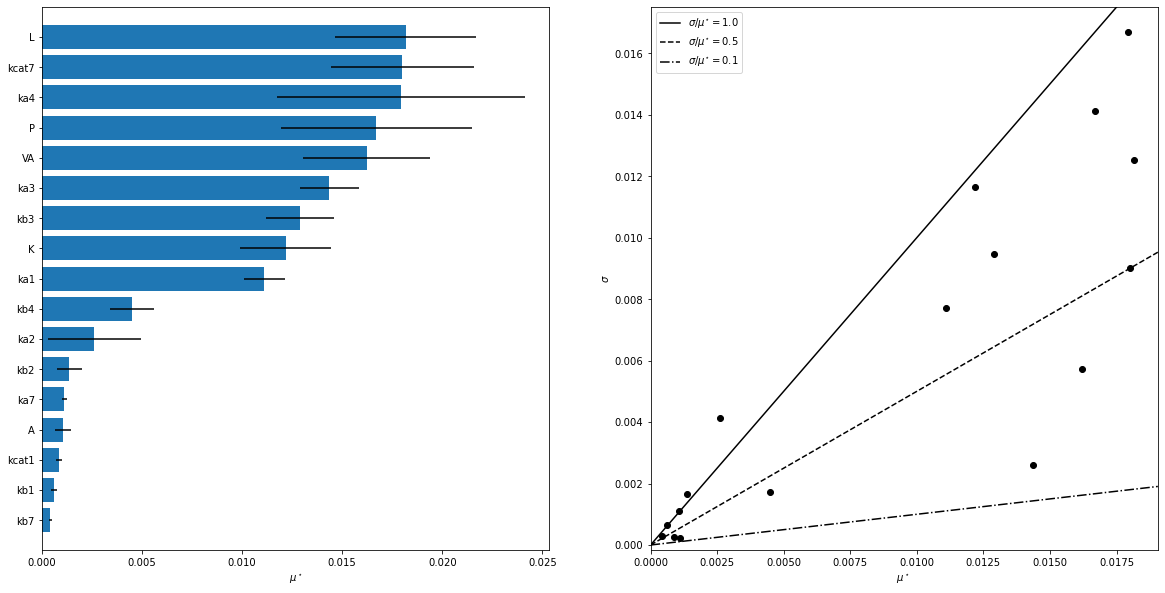

In [32]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
horizontal_bar_plot(ax1,Si,{},sortby='mu_star')
covariance_plot(ax2,Si,{})

## Sobol Method

In [97]:
problem = {
    'num_vars': 13,
    'names': ["ka1", "kb1", "kcat1", "ka2", "kb2", "ka3", "kb3", "ka4","kb4","ka7","kb7","kcat7",'VA'],
    #'groups': ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17'],
    'bounds': [[0,100],[0,1000],[0,500],[0,100],[0,1000],[0,100],[0,1000],[0,100],[0,1000],[0,100],[0,1000],[0,1000],[0,2]]
}


saltelli_samples = saltelli.sample(problem, 2**15)

In [93]:
model = Oscillator(parameter_values, np.array(["ka1", "kb1", "kcat1", "ka2", "kb2", "ka3", "kb3", "ka4","kb4","ka7","kb7","kcat7",'VA']), np.array([0,9,0.6,0.8,0,2.7,0,0,0,0,0,0]), mode=1) 

In [89]:
Y = np.zeros([saltelli_samples.shape[0]])

for i,X in enumerate(saltelli_samples):
    Y[i] = model.eval(X)[0]

Si = sobol.analyze(problem, Y, print_to_console=True, parallel=True, n_processors=36)

/home/local/WIN/jfisch27/miniconda3/envs/oscillations/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


             ST   ST_conf
ka1    0.412758  0.094165
kb1    0.336783  0.089429
kcat1  0.776290  0.144197
ka2    0.872949  0.179877
kb2    3.343027  0.573208
ka3    0.481962  0.094634
kb3    0.498957  0.106155
ka4    0.396597  0.096769
kb4    0.603601  0.142554
ka7    1.234979  0.235836
kb7    1.173461  0.222766
kcat7  0.506510  0.099865
VA     0.410424  0.096609
             S1   S1_conf
ka1    0.000738  0.006955
kb1    0.004996  0.010985
kcat1  0.030115  0.041095
ka2    0.033106  0.031629
kb2    0.013694  0.037331
ka3   -0.004184  0.003845
kb3   -0.002418  0.004231
ka4    0.001956  0.007499
kb4    0.014958  0.032453
ka7   -0.003895  0.007634
kb7    0.032907  0.050278
kcat7  0.000868  0.005937
VA     0.014956  0.022476
                    S2   S2_conf
(ka1, kb1)    0.002540  0.018043
(ka1, kcat1) -0.031352  0.040765
(ka1, ka2)   -0.028722  0.030928
(ka1, kb2)    0.010842  0.052139
(ka1, ka3)    0.021050  0.031062
...                ...       ...
(ka7, kcat7)  0.011732  0.022892
(ka7, VA

In [90]:
#plt.rcParams.update({})
total_Si, first_Si, second_Si = Si.to_df()

total_Si

,ST,ST_conf
ka1,0.412758,0.094165
kb1,0.336783,0.089429
kcat1,0.776290,0.144197
ka2,0.872949,0.179877
kb2,3.343027,0.573208
ka3,0.481962,0.094634
kb3,0.498957,0.106155
ka4,0.396597,0.096769
kb4,0.603601,0.142554
ka7,1.234979,0.235836


<AxesSubplot:>

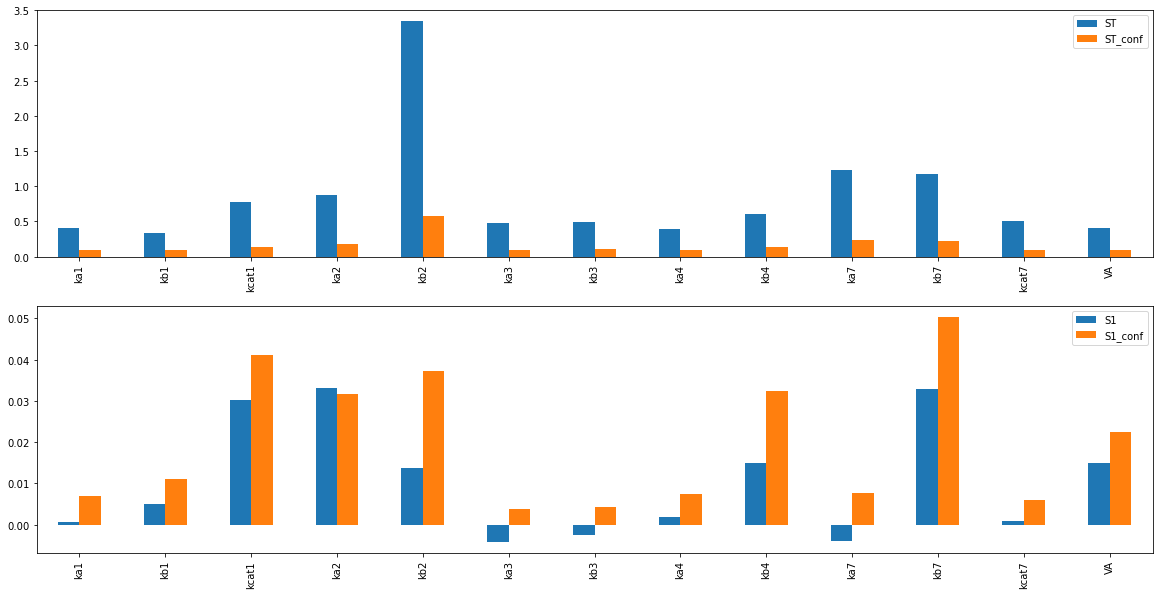

In [91]:
fig, axes = plt.subplots(2,1, figsize=(20,10))
total_Si.plot.bar(ax=axes[0])
first_Si.plot.bar(ax=axes[1])
#second_Si.plot.bar(ax=axes[0,1])

Sobol eval on initial conditions 

In [94]:
problem = {
    'num_vars': 12,
    'names': ["L", "Lp", "K", "P", "LK", "A", "LpA", "LpAK","LpAP","LpAPLp","LpAKL","LpP"],
    #'groups': ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17'],
    'bounds': [[0,10],[0,10],[0,10],[0,10],[0,10],[0,10],[0,10],[0,10],[0,10],[0,10],[0,10],[0,10]]
}

saltelli_samples = saltelli.sample(problem, 2**15)

In [112]:
saltelli_samples.shape

(917504, 13)

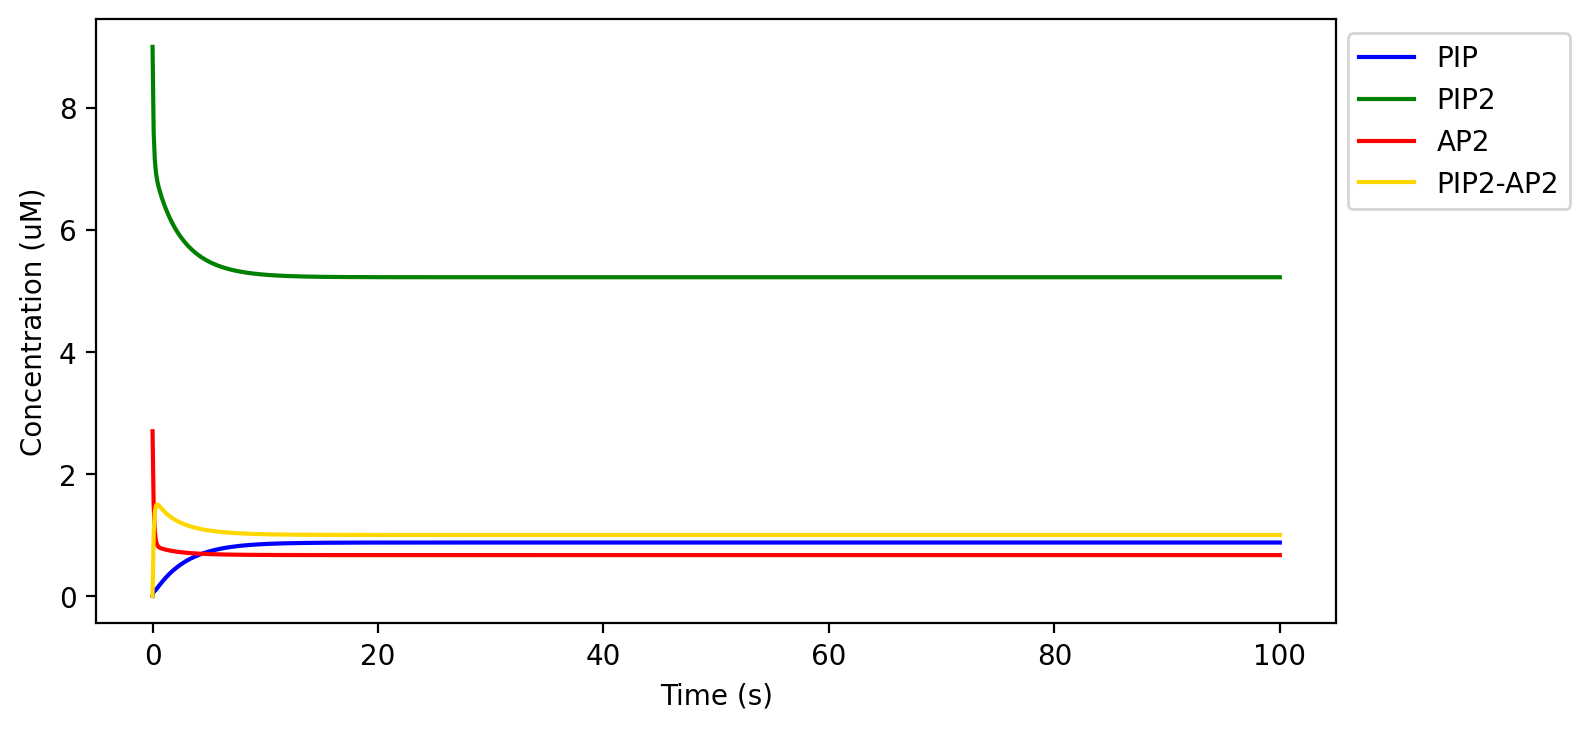

In [116]:
model.plotModel(viablePoints[1000])

/home/local/WIN/jfisch27/miniconda3/envs/oscillations/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


              ST   ST_conf
L       0.511335  0.064486
Lp      0.533963  0.062251
K       0.745957  0.317675
P       0.622724  0.060454
LK      0.730716  0.107873
A       0.802769  0.078658
LpA     0.560873  0.062592
LpAK    0.664020  0.062929
LpAP    0.586027  0.063346
LpAPLp  0.364290  0.056400
LpAKL   0.726083  0.066066
LpP     0.588481  0.071378
              S1   S1_conf
L       0.001161  0.008570
Lp     -0.002557  0.006895
K      -0.000190  0.008264
P       0.013834  0.015572
LK      0.000549  0.009190
A       0.029728  0.014809
LpA     0.002806  0.009225
LpAK    0.005242  0.014064
LpAP    0.009657  0.011340
LpAPLp -0.000841  0.010232
LpAKL   0.001966  0.008999
LpP     0.006764  0.013821
                       S2   S2_conf
(L, Lp)          0.015120  0.016882
(L, K)           0.002793  0.012645
(L, P)           0.015528  0.021008
(L, LK)          0.002498  0.013630
(L, A)           0.013435  0.017881
...                   ...       ...
(LpAP, LpAKL)   -0.005416  0.015138
(LpAP, LpP

<AxesSubplot:>

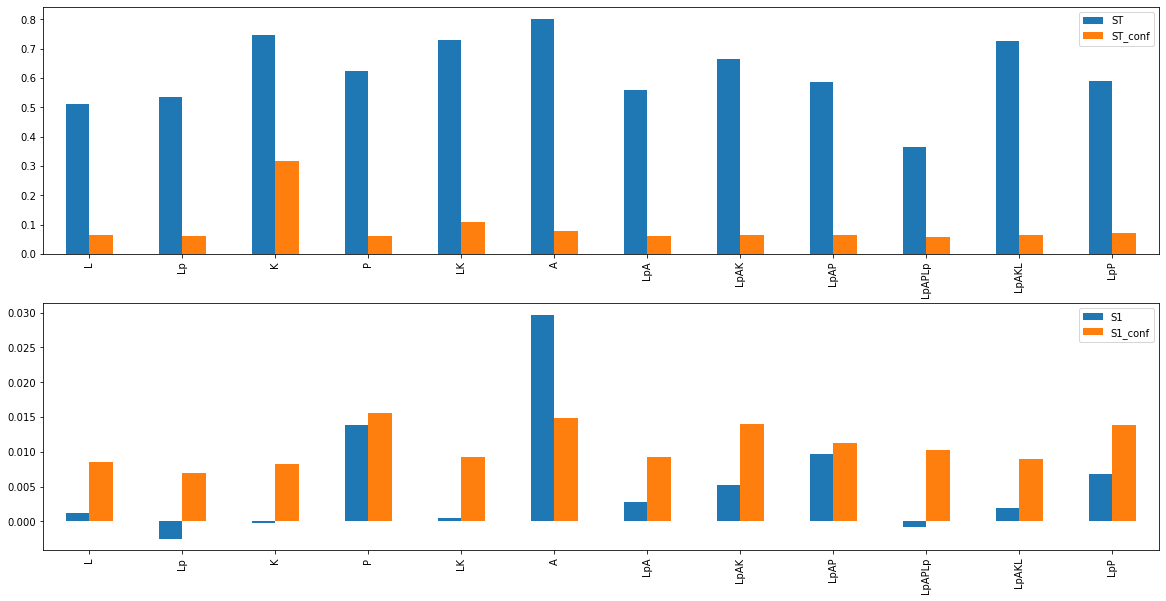

In [95]:
Y = np.zeros([saltelli_samples.shape[0]])
params = viablePoints[0]

for i,X in enumerate(saltelli_samples):
    Y[i] = model.eval_fixedinitials(X,params)[0]

Si = sobol.analyze(problem, Y, print_to_console=True, parallel=True, n_processors=36)

total_Si, first_Si, second_Si = Si.to_df()

fig, axes = plt.subplots(2,1, figsize=(20,10))
total_Si.plot.bar(ax=axes[0])
first_Si.plot.bar(ax=axes[1])

Sobol with amplitude

/home/local/WIN/jfisch27/miniconda3/envs/oscillations/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/local/WIN/jfisch27/miniconda3/envs/oscillations/lib/python3.9/site-packages/SALib/analyze/sobol.py:96: RuntimeWarning: invalid value encountered in true_divide
  Y = (Y - Y.mean()) / Y.std()


Text(0.5, 1.0, 'Amplitude Sensitivity Analysis with fixed initial conditions')

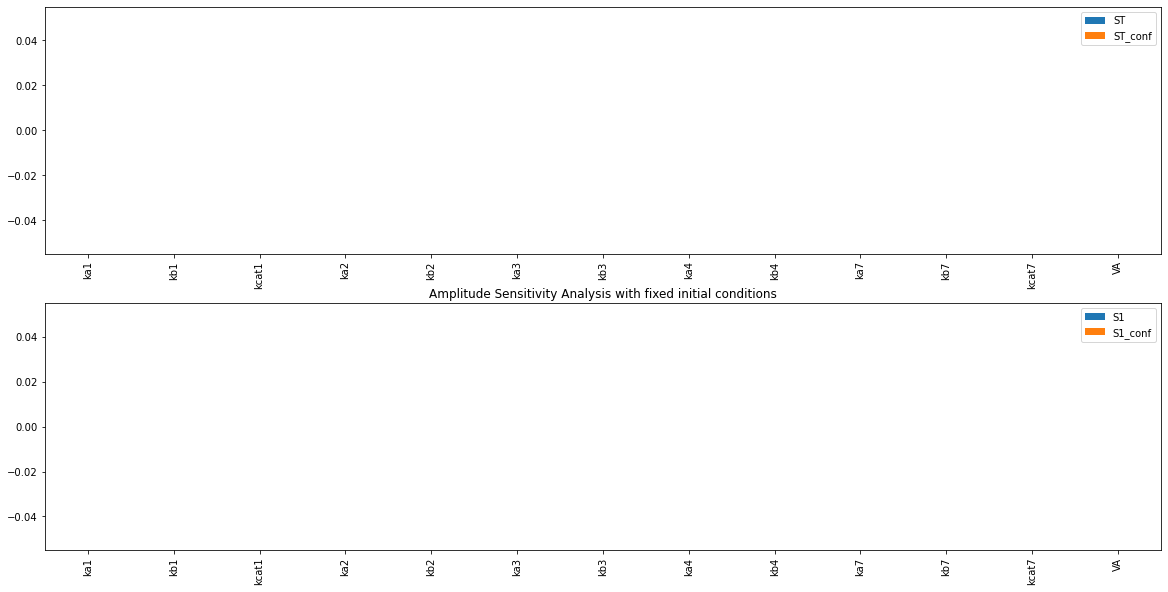

In [98]:
Y = np.zeros([saltelli_samples.shape[0]])

for i,X in enumerate(saltelli_samples):
    Y[i] = model.getPerAmp(X)[0]

Si = sobol.analyze(problem, Y, print_to_console=False, parallel=True,n_processors=36)

total_Si, first_Si, second_Si = Si.to_df()
fig, axes = plt.subplots(2,1, figsize=(20,10))
total_Si.plot.bar(ax=axes[0])
first_Si.plot.bar(ax=axes[1])
plt.title('Amplitude Sensitivity Analysis with fixed initial conditions')

In [99]:
total_Si

,ST,ST_conf
ka1,NaN,NaN
kb1,NaN,NaN
kcat1,NaN,NaN
ka2,NaN,NaN
kb2,NaN,NaN
ka3,NaN,NaN
kb3,NaN,NaN
ka4,NaN,NaN
kb4,NaN,NaN
ka7,NaN,NaN


In [8]:
model.getPerAmp(viablePoints[1])[0]

12.643412643412647

## FAST Method

In [17]:
problem = {
    'num_vars': 13,
    'names': ["ka1", "kb1", "kcat1", "ka2", "kb2", "ka3", "kb3", "ka4","kb4","ka7","kb7","kcat7",'VA'],
    #'groups': ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17'],
    'bounds': [[1e-3,1],[0,100],[0,500],[1e-3,1],[0,1000],[1e-3,1e2],[0,500],[1e-3,1],[0,100],[1e-3,1],[0,1000],[0,200],
                [0.5,1.5]]
}


fast_samples = fast_sampler.sample(problem, 1000)

In [18]:
Y = np.zeros([fast_samples.shape[0]])

for i,X in enumerate(fast_samples):
    Y[i] = model.getPerAmp(X)[0]

Si = fast.analyze(problem, Y, print_to_console=False)

/home/local/WIN/jfisch27/miniconda3/envs/oscillations/lib/python3.9/site-packages/SALib/analyze/fast.py:102: RuntimeWarning: invalid value encountered in double_scalars
  return (D1 / V), (1.0 - Dt / V)


In [21]:
Si

{'S1': [nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  0.008016032064128256,
  nan,
  nan,
  0.008016032064128256,
  nan,
  nan,
  0.008016032064128256],
 'ST': [nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  0.875751503006012,
  nan,
  nan,
  0.875751503006012,
  nan,
  nan,
  0.875751503006012],
 'S1_conf': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
 'ST_conf': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
 'names': ['ka1',
  'kb1',
  'kcat1',
  'ka2',
  'kb2',
  'ka3',
  'kb3',
  'ka4',
  'kb4',
  'ka7',
  'kb7',
  'kcat7',
  'VA']}

## Delta Moment-Independent Method

In [27]:
problem = {
    'num_vars': 13,
    'names': ["ka1", "kb1", "kcat1", "ka2", "kb2", "ka3", "kb3", "ka4","kb4","ka7","kb7","kcat7",'VA'],
    #'groups': ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17'],
    'bounds': [[1e-3,1],[0,100],[0,500],[1e-3,1],[0,1000],[1e-3,1e2],[0,500],[1e-3,1],[0,100],[1e-3,1],[0,1000],[0,200],
                [0.5,1.5]]
}


delta_samples = latin.sample(problem, 10000)

In [28]:
Y = np.zeros([delta_samples.shape[0]])

for i,X in enumerate(delta_samples):
    Y[i] = model.getPerAmp(X)[0]

Si = delta.analyze(problem, delta_samples, Y, print_to_console=False)

LinAlgError: Singular matrix detected
This may be due to the sample size (10000) being too small
If this is not the case, check Y values or raise an issue with the
SALib team

In [8]:
folder1 = os.path.join(".", "/Users/jonathanfischer/Desktop/Desktop - Jonathan’s MacBook Air/Oscillator/Python/2022_simple_system/2d_troubleshooting/PEPE/7-25-22")   
			
				
file1 =  os.path.join(folder1, "7-12_Region001ViableSet_Iter10.p")    
           

viablePoints = pickle.load(open(file1, "rb"))  

model = Oscillator(parameter_values, np.array(["ka1", "kb1", "kcat1", "ka2", "kb2", "ka3", "kb3", "ka4","kb4","ka7","kb7","kcat7","VA","L","K","P","A"]), np.array([0,0,0,0,0,0,0,0,0,0,0,0]), mode=1)  

###                   ###
###  SSA simulations  ###
###                   ###  

#sample few random points from viable regions for region 2     
readFromFile = False                 

region = viablePoints   

In [146]:

if not readFromFile:
	pickle.dump((t_total_ode, Y_total_ode) ,open("stochastic_simulations_repressilator", "wb+"))       	
	
#plot boxplots
repetitions = 100    
amps = []
pers = []      
ode_amps = []
ode_pers = []

if readFromFile:
	pers, amps = pickle.load(open("stochastic_persamps_repressilator","rb")) 
for i in range(numSamples): 
	print(i) 
	sample = samples[i]
	per, amp = model.getPerAmp(sample, mode="ode", indx=1)   
	ode_amps.append(amp)   
	ode_pers.append(per)    
	
	#if not readFromFile:	
		#curra = []
		#currp = []
		#for j in range(repetitions):
			#per, amp = model2.getPerAmp(sample, mode="ssa", indx=1)  
			#amp = amp/model2.omega    
			#curra.append(amp)  
			#currp.append(per)   		
		#amps.append(curra) 
		#pers.append(currp) 

if not readFromFile:	
	pickle.dump((pers, amps), open("stochastic_persamps_repressilator", "wb+"))  

plt.subplot(1,2,1)	
bp = plt.boxplot(amps)     
for i in range(numSamples):  	
	plt.setp(bp['boxes'][i], color="#0E74C8", linewidth=1.5)    
	plt.setp(bp['caps'][2*i], color="#0E74C8", linewidth=1.5)  
	plt.setp(bp['caps'][2*i + 1], color="#0E74C8", linewidth=1.5) 
	plt.setp(bp['whiskers'][2*i], color="#0E74C8", linewidth=1.5)  
	plt.setp(bp['whiskers'][2*i + 1], color="#0E74C8", linewidth=1.5)   
	plt.setp(bp['fliers'][i], color="#0E74C8") 
	plt.setp(bp['medians'][i], color="#0E74C8", linewidth=1.5)   

	plt.plot([i + 1 - 0.25, i + 1 + 0.25], [ode_amps[i], ode_amps[i]], linewidth=3, color="black")
	
plt.ylabel('Amplitude [$nM$]') 
plt.xlabel('Sample \n \n $\mathbf{(a)}$')  


print(ode_amps)   

plt.subplot(1,2,2) 	
bp = plt.boxplot(pers)   
for i in range(numSamples):  	
	plt.setp(bp['boxes'][i], color="#0E74C8", linewidth=1.5)    
	plt.setp(bp['caps'][2*i], color="#0E74C8", linewidth=1.5)  
	plt.setp(bp['caps'][2*i + 1], color="#0E74C8", linewidth=1.5) 
	plt.setp(bp['whiskers'][2*i], color="#0E74C8", linewidth=1.5)  
	plt.setp(bp['whiskers'][2*i + 1], color="#0E74C8", linewidth=1.5)   
	plt.setp(bp['fliers'][i], color="#0E74C8") 
	plt.setp(bp['medians'][i], color="#0E74C8", linewidth=1.5)   

	plt.plot([i + 1 - 0.25, i + 1 + 0.25], [ode_pers[i], ode_pers[i]], linewidth=3, color="black")
	
plt.ylabel('Period [$h$]') 
plt.xlabel('Sample \n \n $\mathbf{(b)}$')  

print(ode_pers)   	
plt.show() 


NameError: name 't_total_ode' is not defined

0
amp4.757505600875621
per10.257749636319893
1
amp2.2566237453434868
per8.818288182881826
2
amp2.220737341306991
per6.375374098568574
3
amp3.1216301735112433
per9.180881282497035
4
amp4.4389213744626534
per16.812723682792384
5
amp3.514949366948914
per9.642485313742025
6
amp4.69021033378981
per21.55421554215542
7
amp4.65724826036362
per11.93461934619346
8
amp2.698717946301776
per5.258909731954461


IndexError: list index out of range

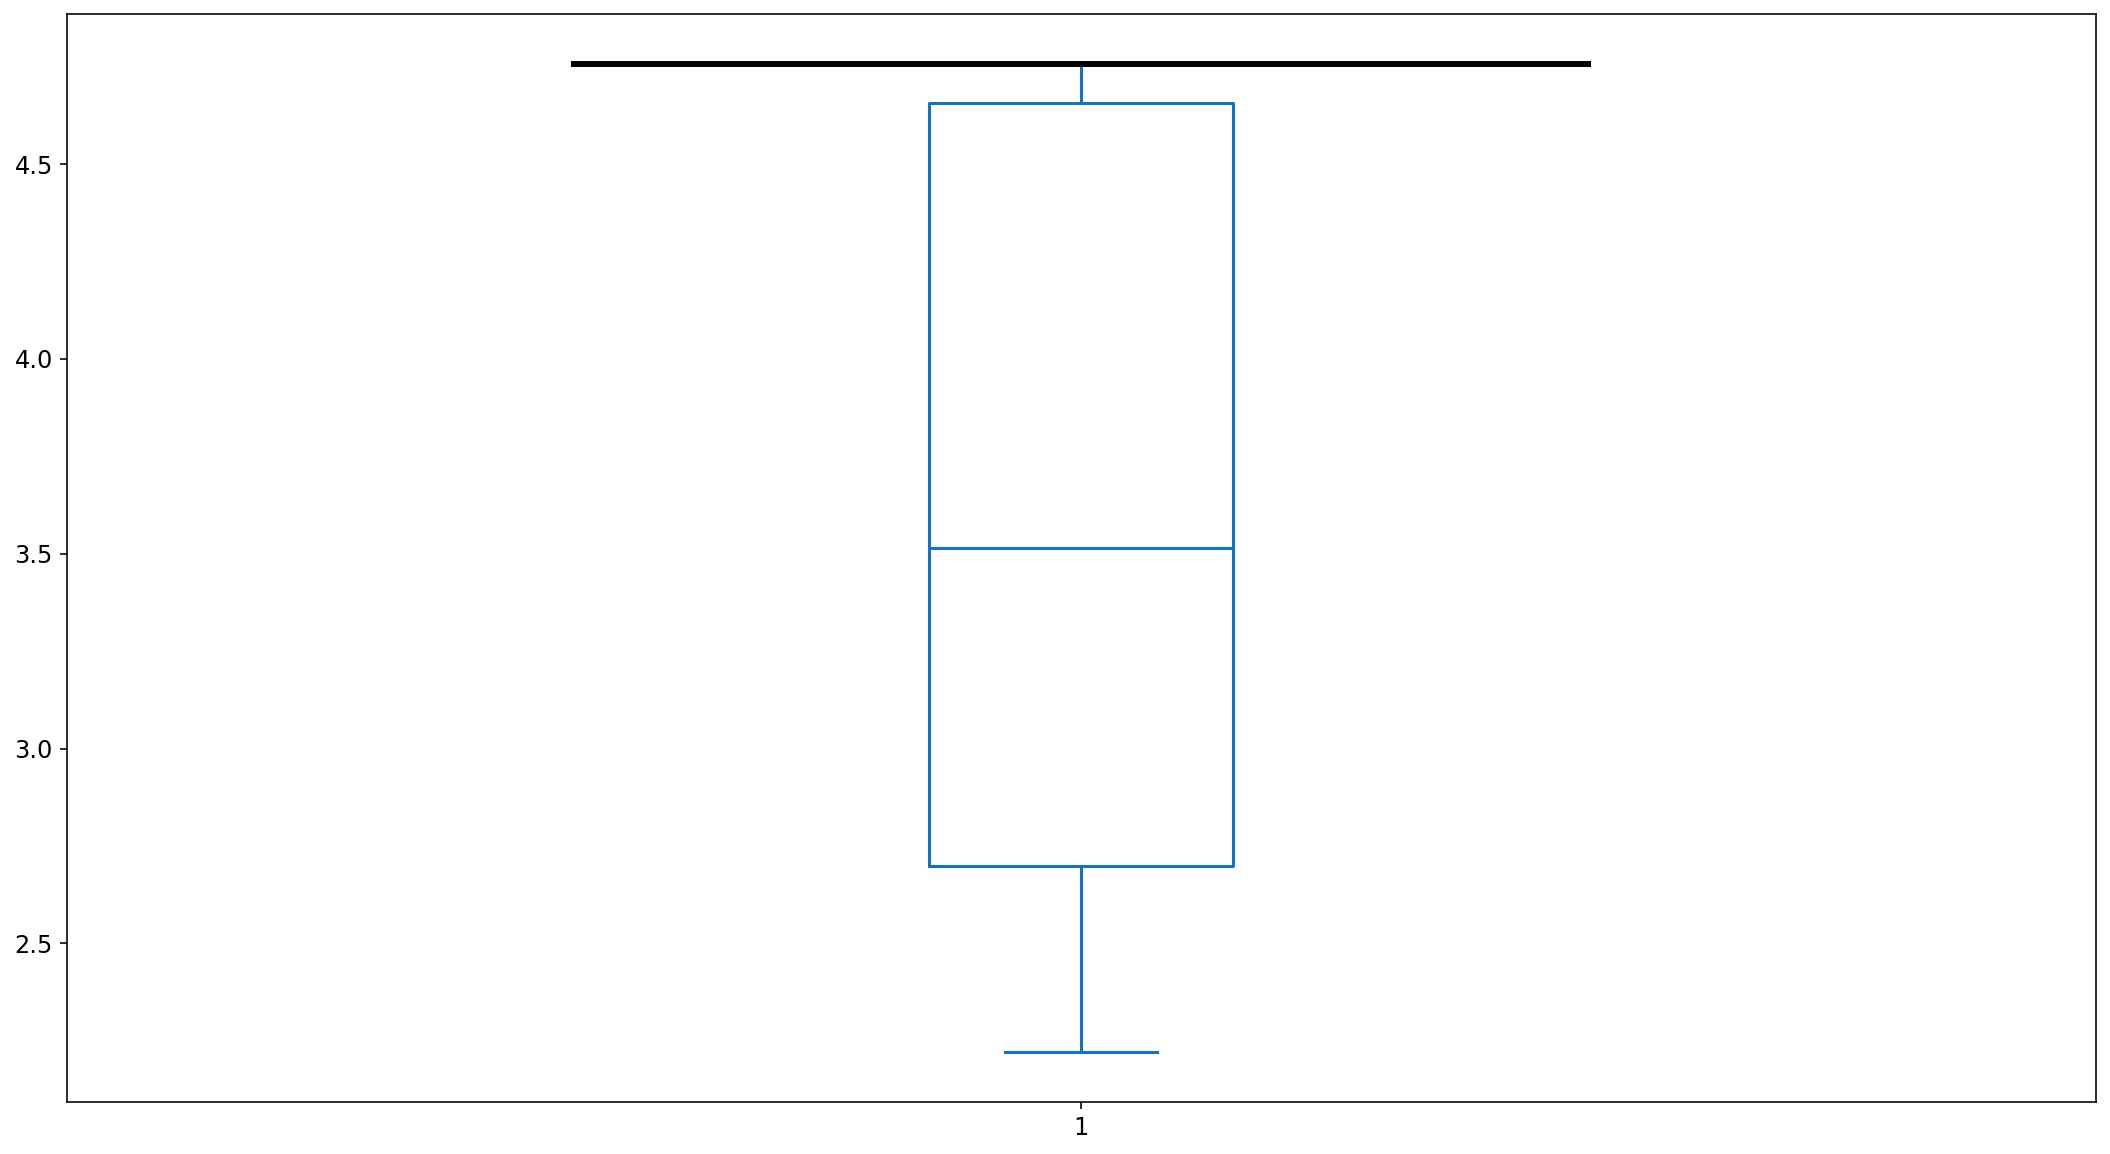

In [147]:
#plot boxplots
repetitions = 100    
amps = []
pers = []      
ode_amps = []
ode_pers = []

if readFromFile:
	ode_pers, ode_amps = pickle.load(open("ode_persamps_repressilator","rb")) 
for i in range(numSamples): 
	print(i) 
	sample = samples[i]
	per, amp = model.getPerAmp(sample, mode="ode", indx=1)   
	ode_amps.append(amp)   
	ode_pers.append(per)    
	
	#if not readFromFile:	
		#curra = []
		#currp = []
		#for j in range(repetitions):
			#per, amp = model2.getPerAmp(sample, mode="ssa", indx=1)  
			#amp = amp/model2.omega    
			#curra.append(amp)  
			#currp.append(per)   		
		#amps.append(curra) 
		#pers.append(currp) 

if not readFromFile:	
	pickle.dump((ode_pers, ode_amps), open("ode_persamps_repressilator", "wb+"))  



plt.subplot(1,2,1)	
bp = plt.boxplot(ode_amps)     
for i in range(numSamples):  	
	plt.setp(bp['boxes'][i], color="#0E74C8", linewidth=1.5)    
	plt.setp(bp['caps'][2*i], color="#0E74C8", linewidth=1.5)  
	plt.setp(bp['caps'][2*i + 1], color="#0E74C8", linewidth=1.5) 
	plt.setp(bp['whiskers'][2*i], color="#0E74C8", linewidth=1.5)  
	plt.setp(bp['whiskers'][2*i + 1], color="#0E74C8", linewidth=1.5)   
	plt.setp(bp['fliers'][i], color="#0E74C8") 
	plt.setp(bp['medians'][i], color="#0E74C8", linewidth=1.5)   

	plt.plot([i + 1 - 0.25, i + 1 + 0.25], [ode_amps[i], ode_amps[i]], linewidth=3, color="black")
	
plt.ylabel('Amplitude [$nM$]') 
plt.xlabel('Sample \n \n $\mathbf{(a)}$')  


print(ode_amps)   

plt.subplot(1,2,2) 	
bp = plt.boxplot(ode_pers)   
for i in range(numSamples):  	
	plt.setp(bp['boxes'][i], color="#0E74C8", linewidth=1.5)    
	plt.setp(bp['caps'][2*i], color="#0E74C8", linewidth=1.5)  
	plt.setp(bp['caps'][2*i + 1], color="#0E74C8", linewidth=1.5) 
	plt.setp(bp['whiskers'][2*i], color="#0E74C8", linewidth=1.5)  
	plt.setp(bp['whiskers'][2*i + 1], color="#0E74C8", linewidth=1.5)   
	plt.setp(bp['fliers'][i], color="#0E74C8") 
	plt.setp(bp['medians'][i], color="#0E74C8", linewidth=1.5)   

	plt.plot([i + 1 - 0.25, i + 1 + 0.25], [ode_pers[i], ode_pers[i]], linewidth=3, color="black")
	
plt.ylabel('Period [$h$]') 
plt.xlabel('Sample \n \n $\mathbf{(b)}$')  

print(ode_pers)   	
plt.show()    

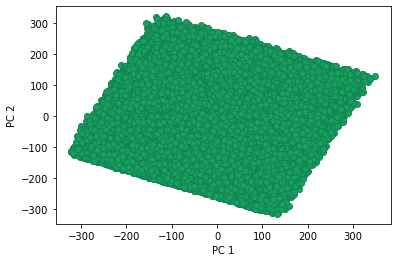

In [9]:
#plot dterministic simulation    	
#simulationPoint = [49.61, 1.43, 4.4, 21.83, 1.72, 0.78, 123.12] 
#model1.getPerAmp(simulationPoint, mode="ode", indx=1)   

#region1 = solver.Region(viablePoints1, model1, "region1") 
pca = PCA(n_components=2)    
pca.fit(allViablePoints)
regionTwo = Region(allViablePoints, model, "region2")     

#region1PCA = pca.transform(viablePoints1)
region2PCA = pca.transform(allViablePoints)  

#plot overlap of both regions 
plt.scatter(region2PCA[:, 0], region2PCA[:, 1], c="#15A357", alpha=1, edgecolor="#158257",  rasterized=True)  
#plt.scatter(region1PCA[:, 0], region1PCA[:, 1], c="#0E74C8", alpha=0.5, edgecolor="#0E56C8",  rasterized=True)
plt.xlabel('PC 1')
plt.ylabel('PC 2') 
plt.show()
#plot points on pca projections  
#filesA = ["represViableSet_IterGA.p", "repres_Region0ViableSet_Iter1.p", "repres_Region0ViableSet_Iter9.p"] 
#filesB = ["repres_Region0CandidateSet_Iter1.p", "repres_Region0CandidateSet_Iter2.p", "repres_Region0CandidateSet_Iter10.p"] 

#pca1 = PCA(n_components=2) 
#pca2 = PCA(n_components=2) 

#pointsa = pickle.load(open('/home/local/WIN/jfisch27/Desktop/Oscillator/Python/2022_simple_system/2d troubleshooting/FreeKinaseSIMPLE2_oscillatorCostTwo_Region0100101ViableSet_Iter10.p', "rb"))
#pointsb = pickle.load(open(path.join(folder2, filesA[0]) , "rb")) 

#pca1.fit(pointsb) 
#pca2.fit(pointsa)  

In [ ]:
#plot viable regions in PCA space     
plt.rcParams.update({'font.size': 12})
i = 1
iters = [1, 2, 10] 
for filea, fileb in zip(filesA, filesB):	

	file1a =  path.join(folder1, filea)     
	file2a =  path.join(folder2, filea)    
	file1b =  path.join(folder1, fileb)     
	file2b =  path.join(folder2, fileb)   	

	viablePoints1 = pickle.load(open(file1a, "rb"))    
	viablePoints2 = pickle.load(open(file2a, "rb"))  
	
	candidatePoints1 = pickle.load(open(file1b, "rb"))  
	candidatePoints2 = pickle.load(open(file2b, "rb"))

	region1PCA = pca1.transform(viablePoints1) 
	region2PCA = pca2.transform(viablePoints2) 
	
	region1PCAcandidates = pca1.transform(candidatePoints1) 
	region2PCAcandidates = pca2.transform(candidatePoints2)   

	ax1=plt.subplot(2, 3, i) 
	ax1.title.set_text("Iteration " + str(iters[i-1]))

	plt.scatter(region1PCAcandidates[:, 0], region1PCAcandidates[:, 1], c="#A62B21", alpha=1, edgecolor='#922B21', rasterized=True)  
	plt.scatter(region1PCA[:, 0], region1PCA[:, 1], c="#0E8DC8", alpha=1, edgecolor="#0E5AC8", rasterized=True)    
	if i == 1:
		plt.ylabel('PC 2')  
	if i == 2:
		plt.xlabel(r"$\bf{(a)}}$")   	 	

	ax1=plt.subplot(2, 3, i + 3) 
	plt.scatter(region2PCAcandidates[:, 0], region2PCAcandidates[:, 1], c="#A62B21", alpha=1, edgecolor='#922B21', rasterized=True)   	
	plt.scatter(region2PCA[:, 0], region2PCA[:, 1], c="#0E8DC8", alpha=1, edgecolor="#0E5AC8", rasterized=True)  
	if i == 2:
		plt.xlabel("PC 1 \n"+ r"$\bf{(c)}$") 
	else:
		plt.xlabel("PC 1")   
	if i == 1:
		plt.ylabel('PC 2')    
	
	i += 1
plt.show()	 

In [ ]:
solver_object = solver.Solver(model1)
viableSets = [region1, region2]   		
paramNames = [r"$\alpha$", r"$\alpha_0$",r"$n$", r"$\beta$",r"$\delta_m$", r"$\delta_p$",r"$Kd$"] 
units = [r"[$h^{-1}$]", r"[$h^{-1}$]", "", r"[$h^{-1}$]", r"[$h^{-1}$]", r"[$h^{-1}]$",r"[$nM$]"]    
solver_object.plotParameterVariances(viableSets, names=paramNames, units=units)         


#plot few repressilator responses 	  
print("plotting model 2") 	
number = np.size(viablePoints1, 0)   
rndPoints = np.random.randint(number, size=10)  
for pnt in rndPoints:     
	print(viablePoints1[pnt,:])     
	model1.plotModel(viablePoints1[pnt,:]) 
	model1.plotModel(viablePoints1[pnt,:], mode="ssa")      	
print("plotting model 2")  	
number = np.size(viablePoints2, 0)     
rndPoints = np.random.randint(number, size=10)   
for pnt in rndPoints:    
	model2.plotModel(viablePoints2[pnt,:])   
	model2.plotModel(viablePoints2[pnt,:], mode="ssa")    	


#calculate viable volume for both cases and determine deviations 
solver_object = solver.Solver(model1) 
vol1 = solver_object.getViableVolume([region1], 100000) 
solver_object = solver.Solver(model2)    
vol2 = solver_object.getViableVolume([region2], 100000)      

print("Region 2 is " + str(vol2/vol1) + "greater than Region 1.")      

In [10]:
parameter_values = {  "ka1": {"min": 1000/1e6, "max": 1e6/1e6},  
            "kb1": {"min": 0, "max": 100},             				        
            "kcat1": {"min": 0, "max": 500},         
            "ka2": {"min": 1000/1e6, "max": 1e6/1e6},         
            "kb2": {"min": 0, "max": 1000}, 
            "ka3": {"min": 1e3/1e6, "max":1e8/1e6}, 
            "kb3": {"min": 0, "max":500},
            "ka4": {"min": 1e3/1e6, "max":1e6/1e6},
            "kb4": {"min": 0, "max": 100},  
            "ka7": {"min": 1e3/1e6, "max": 1e6/1e6}, 
            "kb7": {"min": 0, "max": 1000}, 
            "kcat7": {"min": 0, "max": 200},
            "V": {"min": 0.05, "max": 0.1},
            "VA": {"min": 0.5, "max": 1.5},
            "sigma": {"min": 0.001, "max": 0.01},
            "L": {"min": 1, "max": 1e2},  
            "Lp": {"min": 0.001, "max": 0.01}, 
            "K": {"min": 0.1, "max": 1},
            "P": {"min": 0.1, "max": 1},
            "LK": {"min": 0.001, "max": 0.01}, 
            "A": {"min": 1, "max": 100}, 
            "LpA": {"min": 0.001, "max": 0.01},
            "LpAK": {"min": 0.001, "max": 0.01}, 
            "LpAP": {"min": 0.001, "max": 0.01}, 	
            "LpAPLp": {"min": 0.001, "max": 0.01},
            "LpAKL": {"min": 0.001, "max": 0.01},
            "LpP": {"min": 0.001, "max": 0.01},
            }   	

filename =  os.path.join(".", "unrealFreeKinaseSIMPLE2_oscillatorCostTwo")  
print(filename)   
model = Oscillator(parameter_values, np.array(["ka1", "kb1", "kcat1", "ka2", "kb2", "ka3", "kb3", "ka4","kb4","ka7","kb7","kcat7","V","VA","sigma","L","Lp","K","P","LK","A","LpA","LpAK","LpAP","LpAPLp","LpAKL","LpP"]), np.array(["L","Lp","K","P",0,"A",0,0,0,0,0,0]), mode=1)  
solver = Solver(model) 

./unrealFreeKinaseSIMPLE2_oscillatorCostTwo


/home/local/WIN/jfisch27/miniconda3/envs/oscillations/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/local/WIN/jfisch27/miniconda3/envs/oscillations/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Candidate' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [14]:
viablePoints2 = pickle.load(open('/home/local/WIN/jfisch27/Desktop/Oscillator/Python/2022_simple_system/2d_troubleshooting/PEPE/unrealFreeKinaseSIMPLE2_oscillatorCostTwoViableSet_IterGA.p', "rb")) 

In [18]:
regionTwo = Region(viablePoints2, model, "region2") 

TypeError: object of type 'Region' has no len()

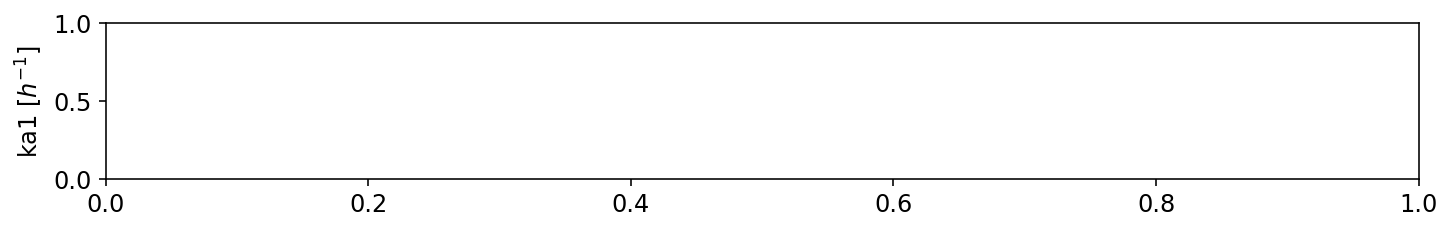

In [157]:
paramNames = ["ka1", "kb1", "kcat1", "ka2", "kb2", "ka3", "kb3", "ka4","kb4","ka7","kb7","kcat7","V","VA","sigma","L","Lp","K","P","LK","A","LpA","LpAK","LpAP","LpAPLp","LpAKL","LpP"] 
units = [r"[$h^{-1}$]", r"[$h^{-1}$]", "", r"[$h^{-1}$]", r"[$h^{-1}$]", r"[$h^{-1}]$",r"[$nM$]"]    
solver.plotParameterVariances(regionTwo, names=paramNames, units=units) 

In [158]:
def plotParameterVariances(self, viableSets, names=None, units=None):      
    #go through all parameters  
    params = self.model.params    
    figure = plt.figure(figsize= (10,25))     
    nRows = math.ceil((len(params)-15)/3)    
    for pcount, param in enumerate(params):
        if pcount < 12:    
            ax1 = plt.subplot(nRows, 3, pcount+1)  
            if names == None:
                ax1.set_title(str(param) + str(pcount))    
            else:
                ax1.set_title(names[pcount])  
            if units != None:
                plt.ylabel(names[pcount] + " " + units[pcount])  
            allRegions = [] 	
            #go through all regions 
            #numSets = len(viableSets) 
            allNames = []
            allBoxes = []
            
            points = np.array(viableSets.points)    
            data = points[:,pcount]   
            allRegions.append(data)   
            #allNames.append("Region " + str(count + 1))   				
            bp = ax1.boxplot(allRegions, sym = '') 
            #self.setBoxColors(bp, numSets, ax1) 		
            allBoxes = bp['boxes'] 
        
    #draw legend 
    #figure.legend(allBoxes, allNames, 'lower right')
    plt.show()     

ValueError: num must be 1 <= num <= 3, not 4

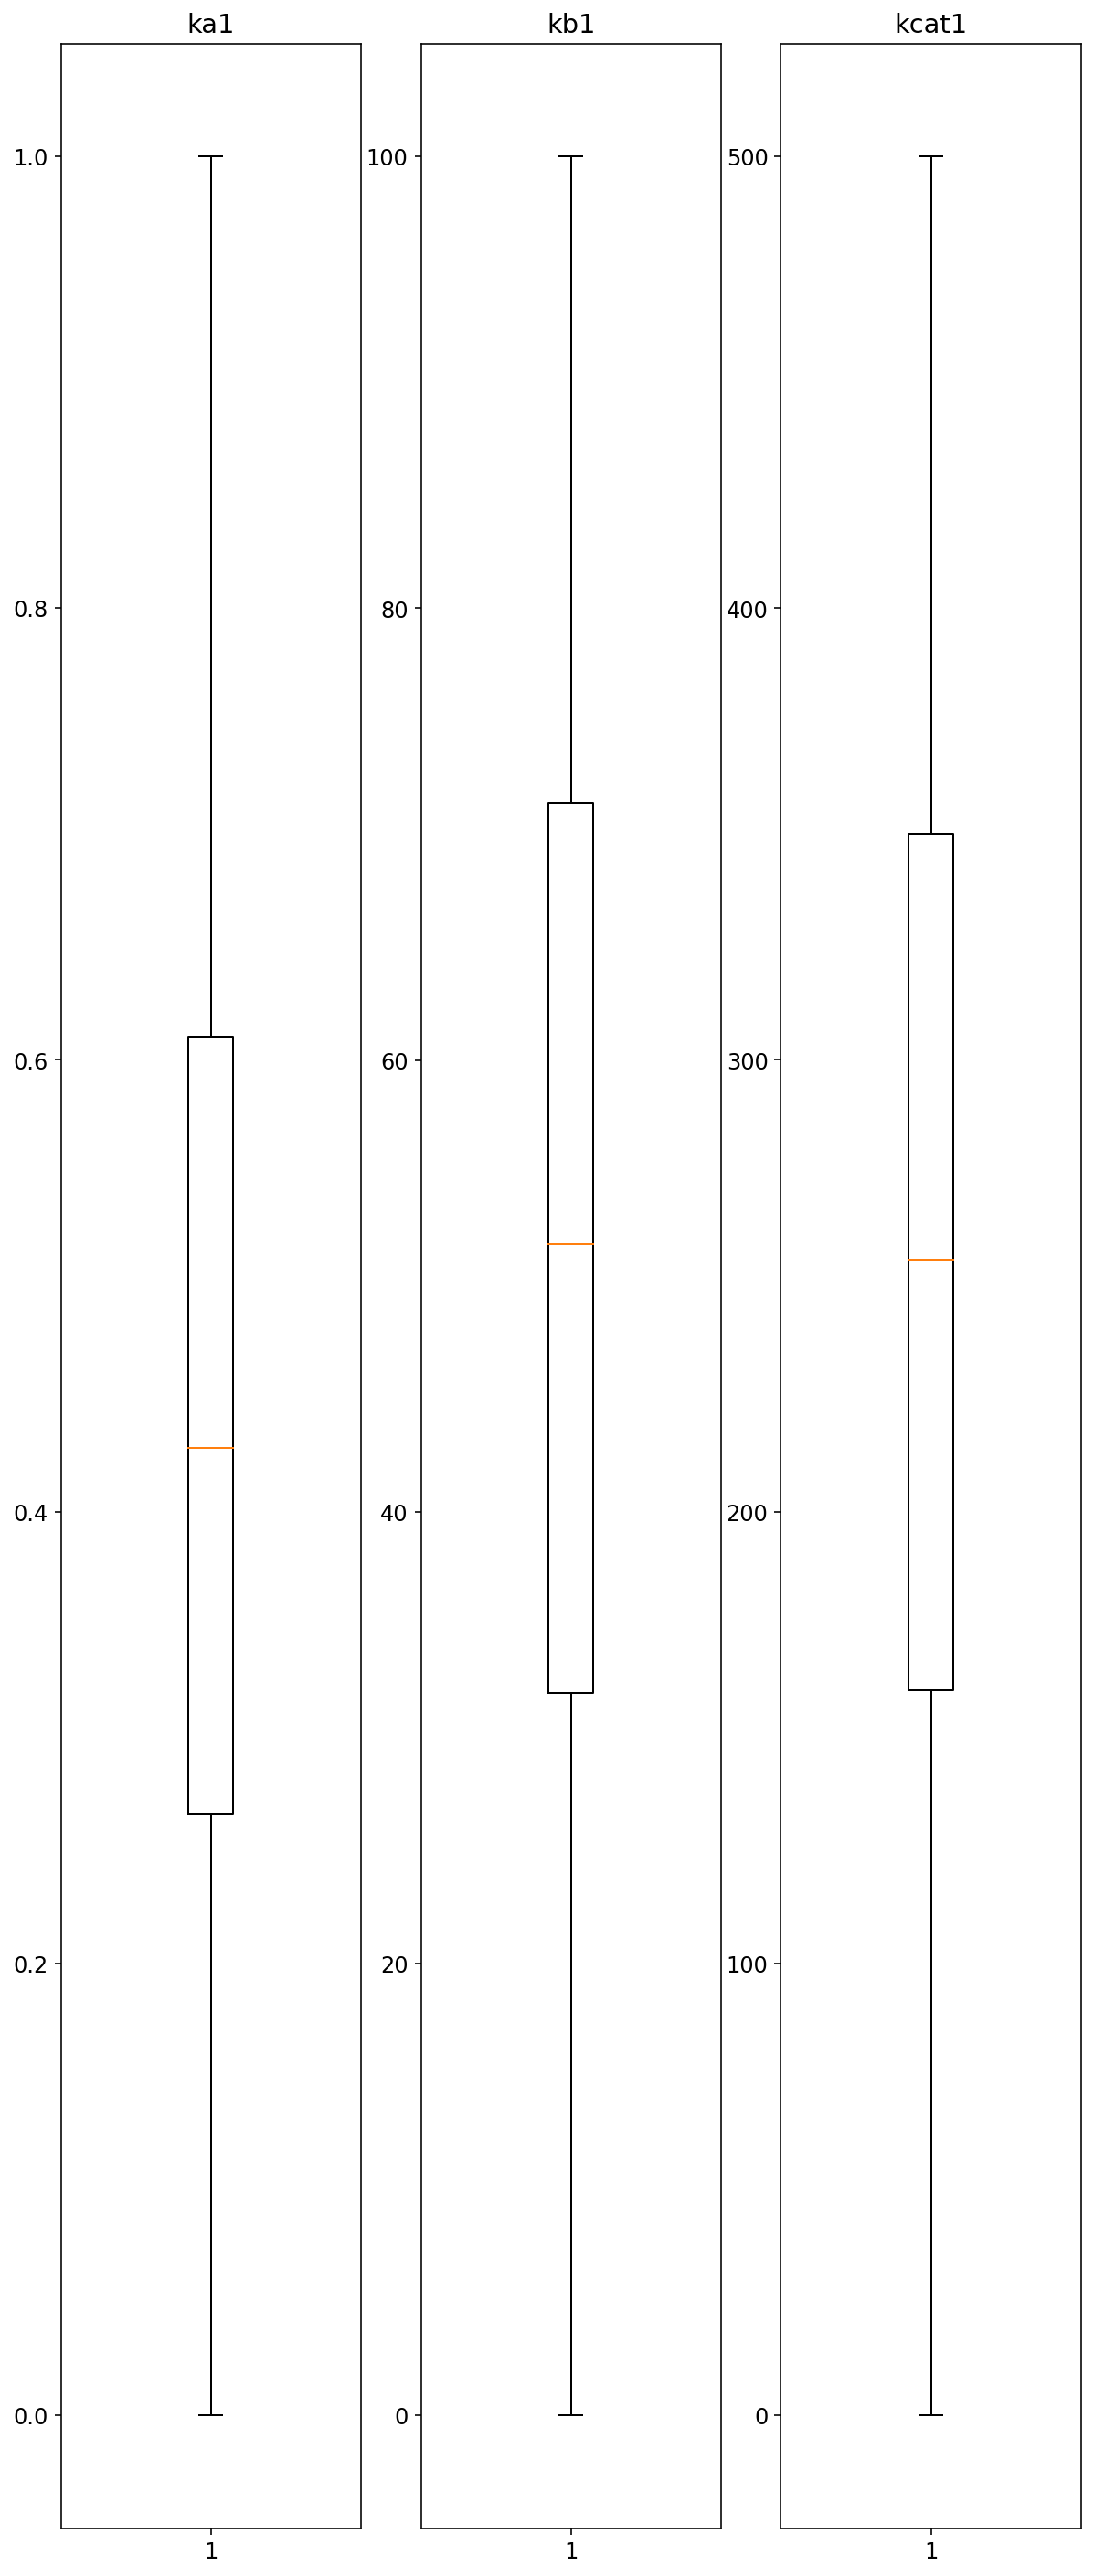

In [189]:
paramNames = ["ka1", "kb1", "kcat1", "ka2", "kb2", "ka3", "kb3", "ka4","kb4","ka7","kb7","kcat7","VA","L","Lp","K","P","LK","A","LpA","LpAK","LpAP","LpAPLp","LpAKL","LpP"] 
units = [r"[$h^{-1}$]", r"[$h^{-1}$]", "", r"[$h^{-1}$]", r"[$h^{-1}$]", r"[$h^{-1}]$",r"[$nM$]"]    
plotParameterVariances(solver,regionTwo, names=paramNames, units=None) 

## Violin plots

In [12]:
points = viablePoints

In [13]:
only_params = points[:,:11]
only_params[1].size

11

In [14]:
only_params = points[:,:12]
#Km1 = only_params[:,1]+only_params[:,2]/only_params[:,0]
#only_params = np.insert(only_params, 1, Km1, axis=1)
Km1 = only_params[:,1]+only_params[:,2]/only_params[:,0]
Kd2 = only_params[:,4]/only_params[:,3]
Kd3 = only_params[:,6]/only_params[:,5]
Kd4 = only_params[:,8]/only_params[:,7]
Km7 = only_params[:,10]+only_params[:,11]/only_params[:,9]
only_params = np.column_stack((only_params,Km1,Kd2,Kd3,Kd4,Km7))
only_params.shape

(5325, 17)

In [13]:
np.column_stack((only_params, Km1,Kd2,Kd3,Kd4,Km7)).shape

(2226, 22)

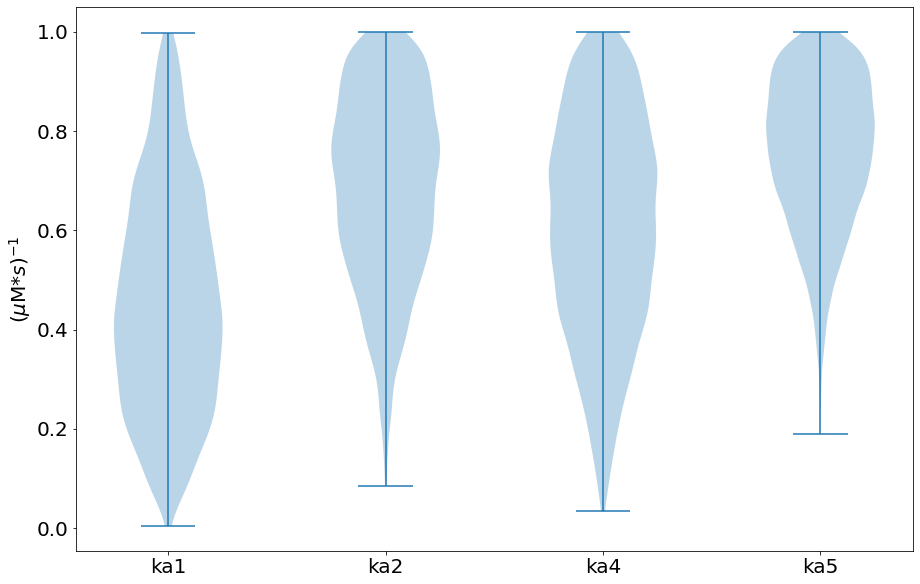

In [22]:
kalist = [only_params[:,0], only_params[:,3], only_params[:,7], only_params[:,9]]
plt.figure(figsize=(15,10))
plt.violinplot(kalist)
plt.xticks([1,2,3,4], ['ka1','ka2','ka4','ka5'], fontsize = '20')
plt.ylabel(r'($\mu$'+'M'+'$*s)^{-1}$', fontsize = 20)
plt.yticks(fontsize = '20')
plt.show()


Text(0, 0.5, '$s^{-1}$')

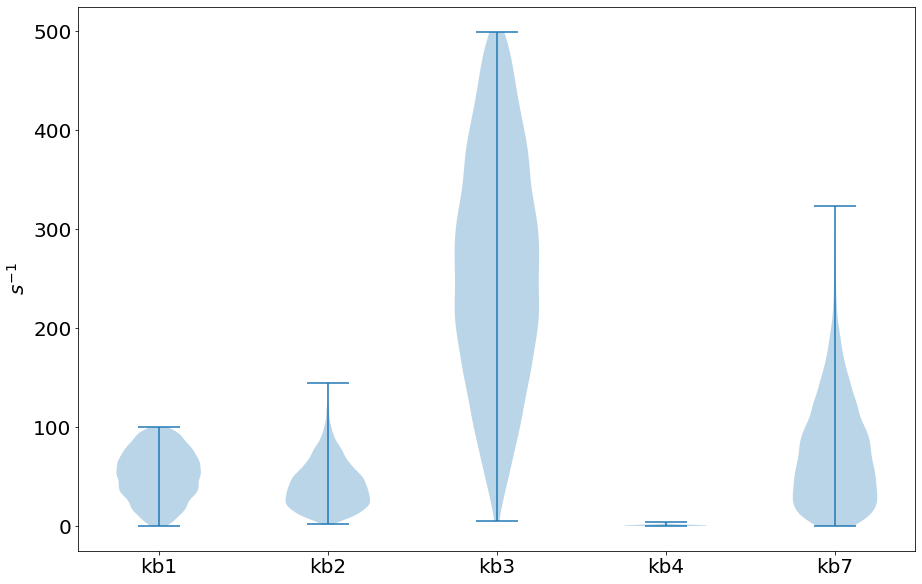

In [23]:
kblist = [only_params[:,1], only_params[:,4], only_params[:,6], only_params[:,8], only_params[:,10]]
plt.figure(figsize=(15,10))
plt.violinplot(kblist)
plt.xticks([1,2,3,4,5], ['kb1','kb2','kb3','kb4', 'kb7'], fontsize = '20')
plt.yticks(fontsize = '20')
plt.ylabel('$s^{-1}$', fontsize = '20')



Text(0, 0.5, '$s^{-1}$')

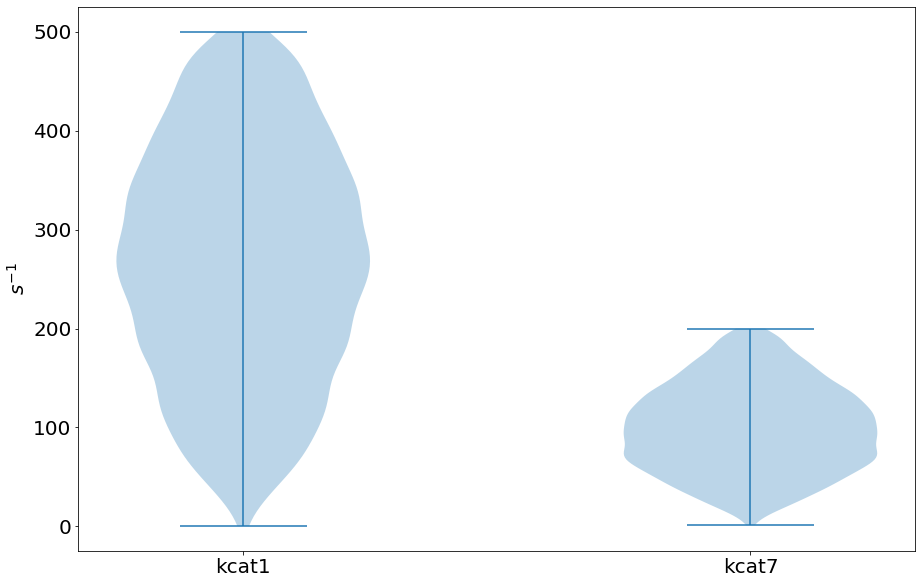

In [24]:
kcatlist = [only_params[:,2], only_params[:,11]]
plt.figure(figsize=(15,10))
plt.violinplot(kcatlist)
plt.xticks([1,2], ['kcat1','kcat7'], fontsize = '20')
plt.yticks(fontsize = '20')
plt.ylabel('$s^{-1}$', fontsize = '20')

Text(0, 0.5, '$\\mu$M')

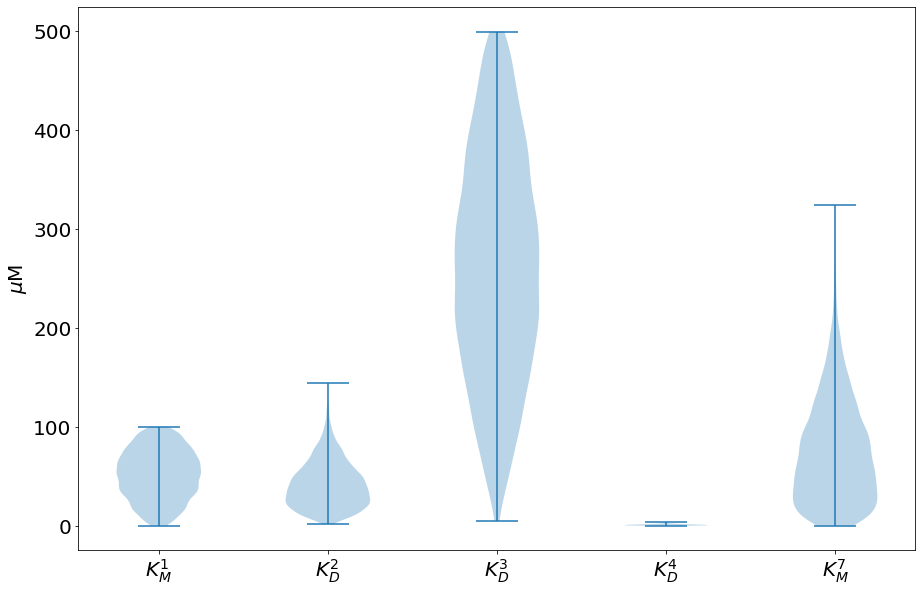

In [30]:
Kdlist = [(only_params[:,1]+only_params[:,2])/only_params[:,0], only_params[:,4]/only_params[:,3],only_params[:,6]/only_params[:,5], only_params[:,8]/only_params[:,7], (only_params[:,10]+only_params[:,11])/only_params[:,9]]
plt.figure(figsize=(15,10))
plt.violinplot(kblist)
plt.xticks([1,2,3,4,5], [r'$K_M^1$',r'$K_D^2$',r'$K_D^3$',r'$K_D^4$', r'$K_M^7$'],fontsize = '20')
plt.yticks(fontsize = '20')
plt.ylabel(r'$\mu$'+'M',fontsize = '20')

In [79]:
def prep_boxplot(region):
    points = np.array(region.points)
    only_params = points[:,:11]
    Km1 = only_params[:,1]+only_params[:,2]/only_params[:,0]
    Kd2 = only_params[:,4]/only_params[:,3]
    Kd3 = only_params[:,6]/only_params[:,5]
    Kd4 = only_params[:,8]/only_params[:,7]
    Km7 = only_params[:,10]+only_params[:,11]/only_params[:,9]
    only_params = np.column_stack((only_params,Km1,Kd2,Kd3,Kd4,Km7))

    return only_params


## Local sensitivity 

In [18]:
import numdifftools.nd_algopy as nda

In [40]:
point = np.ndarray.tolist(points[100])
point

[0.5399439956871153,
 32.49731125365913,
 459.0713154241908,
 0.6703697205723796,
 98.55386776137301,
 66.94761309866233,
 187.88476784879947,
 0.732829082837601,
 0.5932803922080772,
 0.8833353263653272,
 79.8349667706061,
 98.51067194455857,
 1.21704450980531,
 8.973816043747753,
 0.6170991018130821,
 0.7934153177539267,
 2.6856696379362606]

In [39]:
x = model.simulate(point)
x

array([[8.97381604e+00, 0.00000000e+00, 6.17099102e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.97087407e+00, 5.85017136e-04, 6.14742634e-01, ...,
        2.45932277e-15, 1.36099587e-09, 1.35894609e-07],
       [8.96800241e+00, 2.02006645e-03, 6.13308929e-01, ...,
        2.38806396e-13, 2.72285489e-08, 9.28714846e-07],
       ...,
       [4.15952121e+00, 4.43540579e+00, 5.60582637e-01, ...,
        9.43669156e-02, 3.96750614e-02, 1.47263970e-02],
       [4.15088567e+00, 4.44378270e+00, 5.60561019e-01, ...,
        9.44087748e-02, 3.96732893e-02, 1.47534048e-02],
       [4.14226059e+00, 4.45214988e+00, 5.60539723e-01, ...,
        9.44506504e-02, 3.96712121e-02, 1.47803768e-02]])

In [36]:
type(x[1,1])

numpy.float64

In [24]:
grad = nda.Gradient(model.eval,method='reverse')(point)
grad

ValueError: setting an array element with a sequence.

In [37]:
def testCost(params, model):
    Y = model.simulate(params)
    x = float(Y[1,1])
    return x**2


In [38]:
nda.Gradient(testCost,method='reverse')(point,model)

ValueError: setting an array element with a sequence.

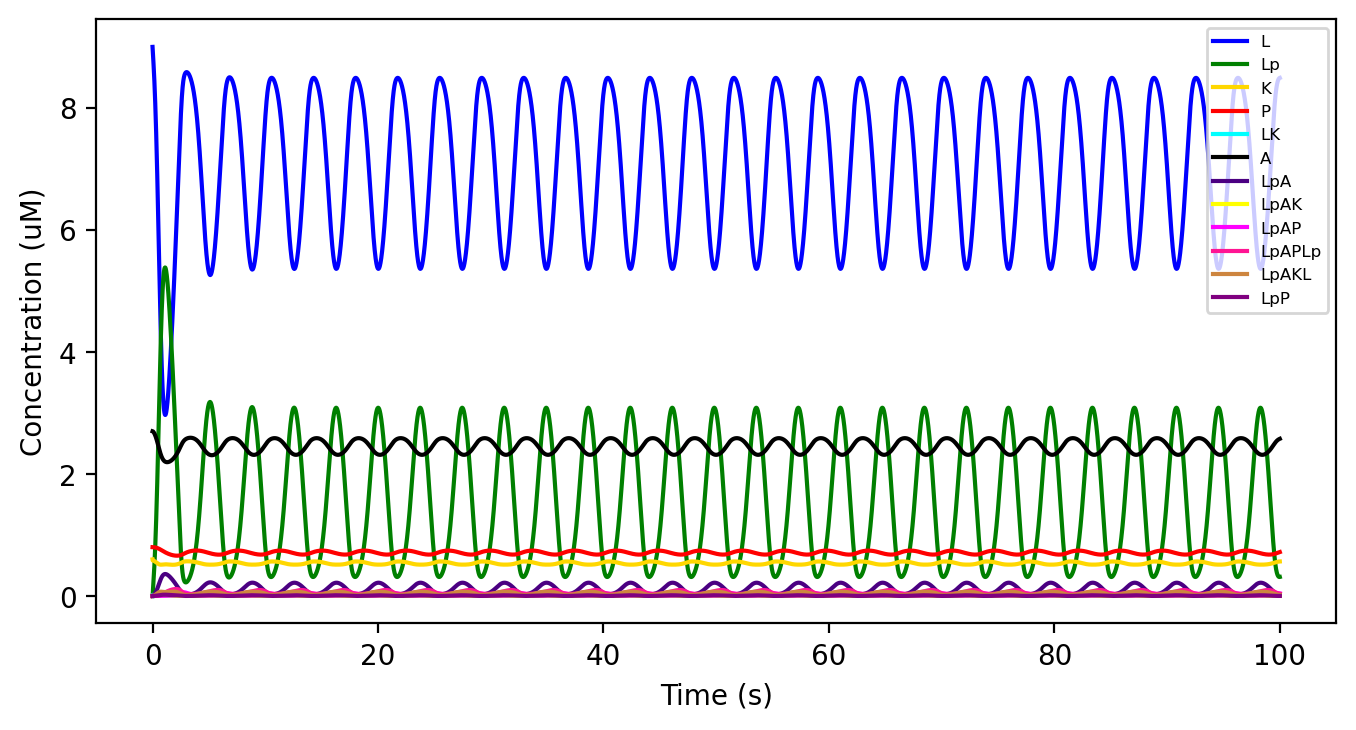

In [19]:
#testY = model.simulate(points[100])

model.plotModel(viablePoints[100])

In [209]:
testY

array([[1.27249259e+01, 0.00000000e+00, 4.38169838e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.27222216e+01, 3.29123657e-04, 4.35794946e-01, ...,
        3.36288368e-16, 2.31167395e-10, 6.98831363e-08],
       [1.27196445e+01, 1.19030130e-03, 4.34080344e-01, ...,
        3.53561983e-14, 4.69465611e-09, 4.97022536e-07],
       ...,
       [9.13392164e+00, 3.33030723e+00, 3.94849565e-01, ...,
        4.88683618e-02, 3.34440131e-02, 1.18070166e-02],
       [9.13003501e+00, 3.33401825e+00, 3.94826192e-01, ...,
        4.88919558e-02, 3.34656043e-02, 1.18196880e-02],
       [9.12614729e+00, 3.33773034e+00, 3.94802843e-01, ...,
        4.89155709e-02, 3.34871702e-02, 1.18323616e-02]])

In [211]:
points[100].shape

(17,)